In [1]:
# Monte Carlo Interpretation

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../src/')
from reRoute_Dynamics import Object_Params as op
df = pd.read_pickle('./KC_Example_Data/MC_Saves/1_0.pk')

In [2]:
def convert_to_single_col(df, col):
    l = list(df.apply(lambda x: dict(zip([str(x.name)+" "+i for i in [str(n) for n in list(x[col].keys())]], x[col].values())), axis=1))
    d = {k:v for x in l for k,v in x.items()}
    return pd.Series(d).reset_index(drop=True)

In [278]:
def load_single_trip(trip_path):
    df=pd.read_pickle(trip_path)
    df['BP'] = df['BP'].apply(lambda x: x.to_dict())
    
    mi_kwh_m = (df['miles']/df['kwh']).mean()
    mi_kwh_s = (df['miles']/df['kwh']).std()
    mi_kwh_min = (df['miles']/df['kwh']).min()
    mi_kwh_max = (df['miles']/df['kwh']).max()
    
    '''
    fig, ax = plt.subplots(1, 1)
    ax.hist(df['tot_time'])
    '''
    
    time_m = df['tot_time'].mean()
    time_sd = df['tot_time'].std()
    time_min = df['tot_time'].min()
    time_max = df['tot_time'].max()

    
    p = convert_to_single_col(df, 'BP')
    t = convert_to_single_col(df, 'dt')
    g = convert_to_single_col(df, 'g')
    v = convert_to_single_col(df, 'v')
    vel = convert_to_single_col(df, 'vel')
    df = pd.concat([p, t, g, v,vel], axis=1)
    df.rename({0:'BP',1:'dt',2:'g',3:'v',4:'vel'}, axis=1,inplace=True)
    time_tot = t.sum()
    
    '''
    fig, ax = plt.subplots(1,1)
    ax.hist(v, weights=t, bins = np.arange(30, 50, 1))
    plt.show()
    '''
    
    volt_indexes = []
    volt_times = []
    power_indexes =[]
    power_times = []
    volt_bins = np.arange(30, 50, 1)
    power_bins = np.arange(-200000, 500000, 50000)
    for i in range(len(volt_bins)-1):
        binned = df[(df['v'] > volt_bins[i]) & (df['v'] < volt_bins[i+1])]
        frac_time = binned['dt'].sum()/time_tot
        volt_indexes.append((volt_bins[i] + volt_bins[i+1])/2)
        volt_times.append(frac_time)
        
    for i in range(len(power_bins)-1):
        binned = df[(df['BP'] > power_bins[i]) & (df['BP'] < power_bins[i+1])]
        frac_time = binned['dt'].sum()/time_tot
        power_indexes.append((power_bins[i] + power_bins[i+1])/2)
        power_times.append(frac_time)
    
    return {'kwh':[mi_kwh_m, mi_kwh_s, mi_kwh_min, mi_kwh_max],
            'time':[time_m, time_sd,time_min, time_max],
            'grade':[g.mean(), g.std()],
            'vel':[vel.mean(), vel.std()],
            'BP':dict(zip(power_indexes, power_times)),
            'v':dict(zip(volt_indexes, volt_times))}


In [279]:
def get_kwh_stats(df, key):
    minimum = round(df[key].apply(lambda x: x[2]).min(), 4)
    maximum = round(df[key].apply(lambda x: x[3]).max(), 4)
    ave_std = round(df[key].apply(lambda x: x[1]).mean(), 4)
    ave_std_std = round(df[key].apply(lambda x: x[1]).std(), 4)
    ave_mean = round(df[key].apply(lambda x: x[0]).mean(), 4)
    ave_mean_std = round(df[key].apply(lambda x: x[0]).std(), 4)
    return tuple([minimum, maximum, ave_mean, ave_mean_std, ave_std, ave_std_std])

In [447]:
def load_trip_statistics(savepath):
    files = os.listdir(savepath)
    unique_shorts = pd.Series(files).apply(lambda x: x.split('_')[0]).unique()
    sim_dict = {}
    for short in unique_shorts[:]:
        print(short)
        simulations = [x for x in files if short + "_" in x]
        for i in range(len(simulations)):
            simulation = simulations[i]
            sim_dict[simulation] = load_single_trip(savepath + simulation)

    return pd.DataFrame(sim_dict).T


In [448]:
trip_stats = load_trip_statistics('./KC_Example_Data/MC_Saves/')

101
107
10
118
11
124
131
132
14
150
1
21
24
27
28
33
345
346
348
36
3
40
45
48
49
4
50
5
62
65
67
70
75
8


In [449]:
def plot_voltage(df):
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 4), dpi=140)
    vdat = pd.DataFrame(list(df['v']))
    means = vdat.mean().values
    stds = vdat.std().values
    ax[0].errorbar(vdat.columns, means, yerr=stds, fmt='o', capsize = 10)
    ax[0].bar(vdat.columns, means, alpha=.3, width=1)
    major_ticks = np.arange(30, 50, 1)

    ax[0].set_xticks(major_ticks)
    ax[0].set_xticks(ticks = ax[0].get_xticks(), labels=ax[0].get_xticklabels(), rotation=-45)
    ax[0].grid()
    ax[0].set_xlabel('Module Voltage [v]')
    ax[0].set_ylabel('Fraction of Time')
    ax[0].set_title('Time-proportional module voltage & Power distribution')
    # For a route's inbound or outbound direction, these are the aggregated monte-carlo distributions of module voltage.
    
    bdat = pd.DataFrame(list(df['BP']))
    means = bdat.mean().values
    stds = bdat.std().values
    ax[1].errorbar(bdat.columns/1000, means, yerr=stds, fmt='o', capsize = 10)
    ax[1].bar(bdat.columns/1000, means, alpha=.3, width=50)
    major_ticks = np.arange(-200000/1000, 500000/1000, 50000/1000)

    ax[1].set_xticks(major_ticks)
    ax[1].set_xticks(ticks = ax[1].get_xticks(), labels=ax[1].get_xticklabels(), rotation=-45)
    ax[1].grid()
    ax[1].set_xlabel('ESS Power [kW]')
    ax[1].set_ylabel('Fraction of Time')
    # For a route's inbound or outbound direction, these are the aggregated monte-carlo distributions of module load.
    
    
    plt.show()
    return plt

In [450]:
def interpret_trip_statistics(df):
    unique_shorts = pd.Series(df.index).apply(lambda x: x.split('_')[0]).unique()
    for shortname in unique_shorts:
        sdf = df[pd.Series(df.index, index=df.index).apply(lambda x: x.split('_')[0]) == shortname]
        i_df = sdf[pd.Series(sdf.index, index=sdf.index).apply(lambda x: int(x.split('_')[1].split('.')[0])%2 == 0)]
        o_df = sdf[pd.Series(sdf.index, index=sdf.index).apply(lambda x: int(x.split('_')[1].split('.')[0])%2 == 1)]
        
        
        tup = (shortname,) + get_kwh_stats(i_df, 'kwh')
        print("Route {} Inbound: \n\tMilage Min: {} kWh, Max: {} kWh, Average Mean: {}+/-{} kWh, Average STD: {}+/-{} kWh".format(*tup))
        tup = get_kwh_stats(i_df, 'time')
        print('\tTime Min: {} s, Max: {} s, Average Mean: {}+/-{} s, Average STD: {}+/-{} s'.format(*tup))
        tup = (shortname,) + get_kwh_stats(o_df, 'kwh')
        plot_voltage(i_df)
        print("Route {} Outbound: \n\tMilage Min: {} kWh, Max: {} kWh, Average Mean: {}+/-{} kWh, Average STD: {}+/-{} kWh".format(*tup))
        tup =  get_kwh_stats(o_df, 'time')
        print('\tTime Min: {} s, Max: {} s, Average Mean: {}+/-{} s, Average STD: {}+/-{} s'.format(*tup))
        plot_voltage(o_df)
        print()

Route 101 Inbound: 
	Milage Min: 0.2438 kWh, Max: 0.5121 kWh, Average Mean: 0.3448+/-0.0152 kWh, Average STD: 0.0513+/-0.007 kWh
	Time Min: 1719.1553 s, Max: 4395.8523 s, Average Mean: 2832.3163+/-95.8184 s, Average STD: 490.0709+/-28.4329 s


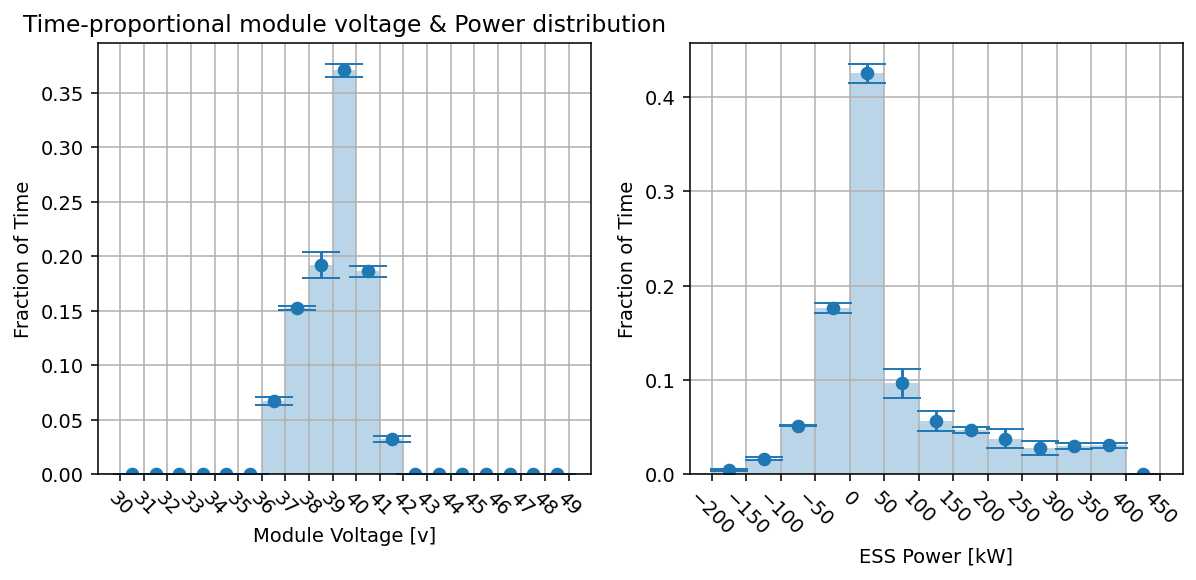

Route 101 Outbound: 
	Milage Min: 0.2406 kWh, Max: 0.5331 kWh, Average Mean: 0.3373+/-0.0259 kWh, Average STD: 0.0487+/-0.0074 kWh
	Time Min: 2026.2979 s, Max: 4516.6811 s, Average Mean: 3038.8352+/-122.4504 s, Average STD: 480.3489+/-24.4729 s


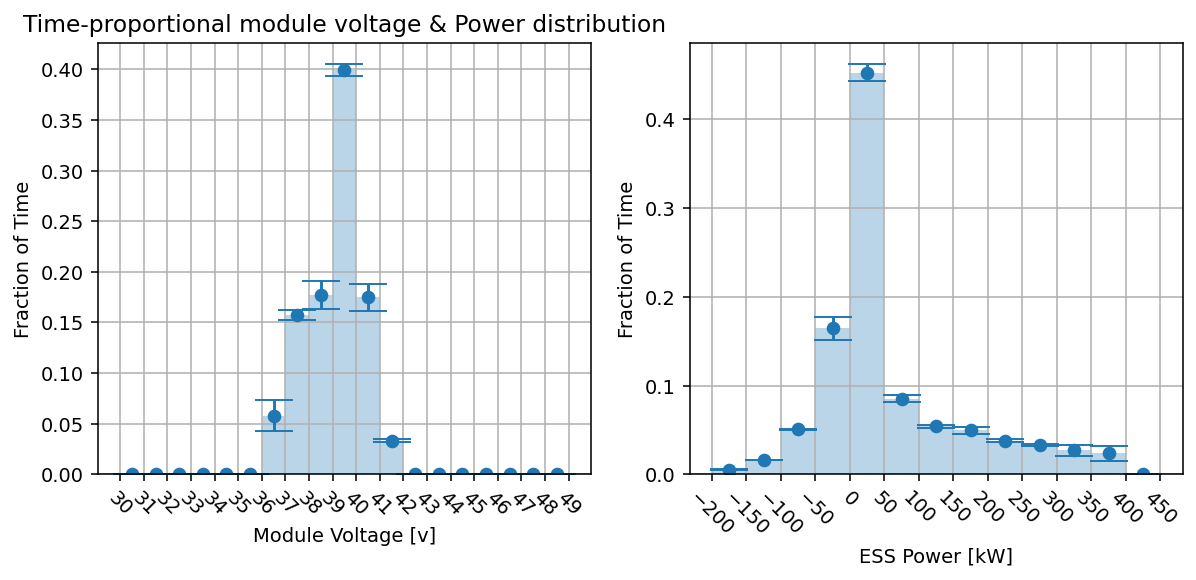


Route 107 Inbound: 
	Milage Min: 0.2571 kWh, Max: 0.6153 kWh, Average Mean: 0.3946+/-0.0245 kWh, Average STD: 0.0644+/-0.0095 kWh
	Time Min: 2043.9632 s, Max: 6473.4289 s, Average Mean: 3889.8528+/-16.1292 s, Average STD: 928.9964+/-9.1161 s


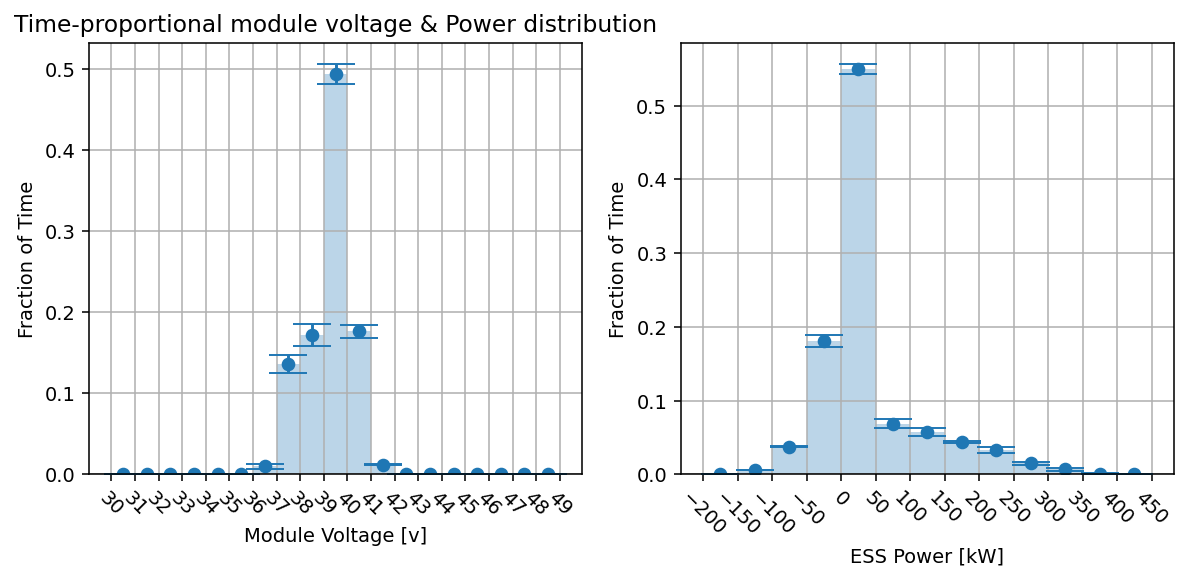

Route 107 Outbound: 
	Milage Min: 0.2415 kWh, Max: 0.6395 kWh, Average Mean: 0.4045+/-0.0322 kWh, Average STD: 0.0692+/-0.0112 kWh
	Time Min: 2129.3971 s, Max: 6406.2842 s, Average Mean: 3817.2104+/-0.4964 s, Average STD: 858.5261+/-9.3498 s


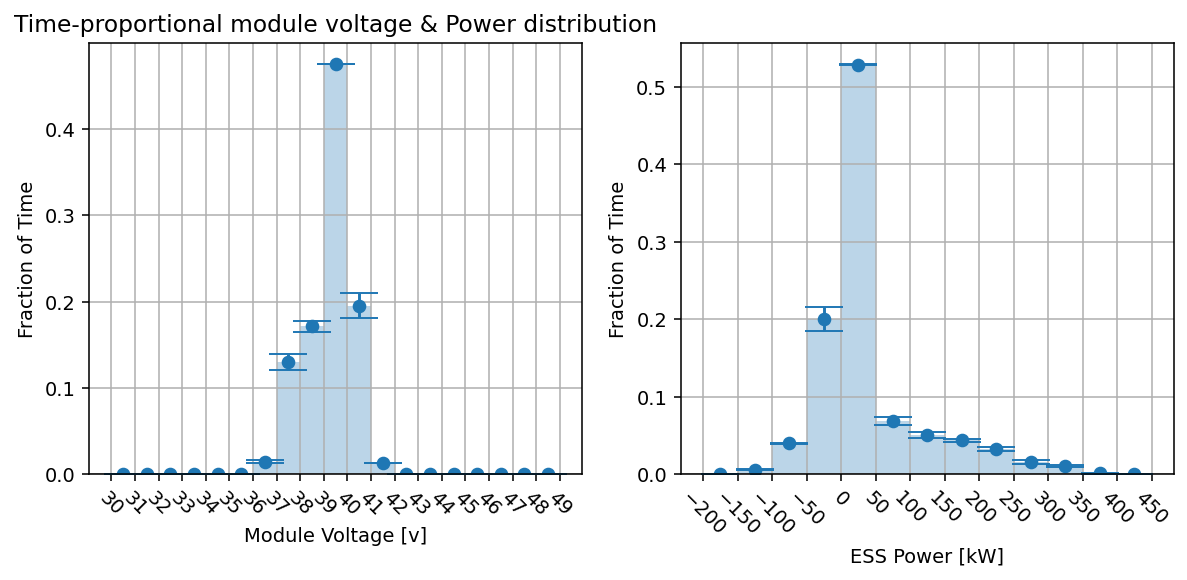


Route 10 Inbound: 
	Milage Min: 0.164 kWh, Max: 0.6716 kWh, Average Mean: 0.3225+/-0.138 kWh, Average STD: 0.0551+/-0.0375 kWh
	Time Min: 414.627 s, Max: 2700.8765 s, Average Mean: 1186.0775+/-442.1507 s, Average STD: 279.527+/-71.6407 s


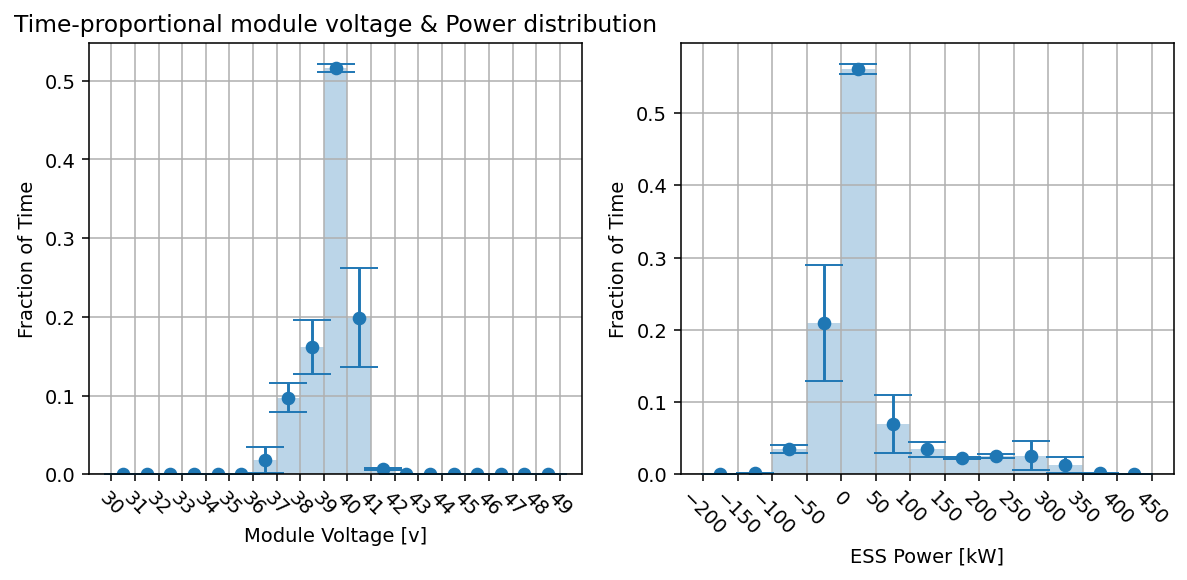

Route 10 Outbound: 
	Milage Min: 0.1826 kWh, Max: 1.6568 kWh, Average Mean: 0.4446+/-0.2609 kWh, Average STD: 0.1165+/-0.1171 kWh
	Time Min: 498.3401 s, Max: 2137.5913 s, Average Mean: 1159.0838+/-300.3377 s, Average STD: 270.4939+/-37.5661 s


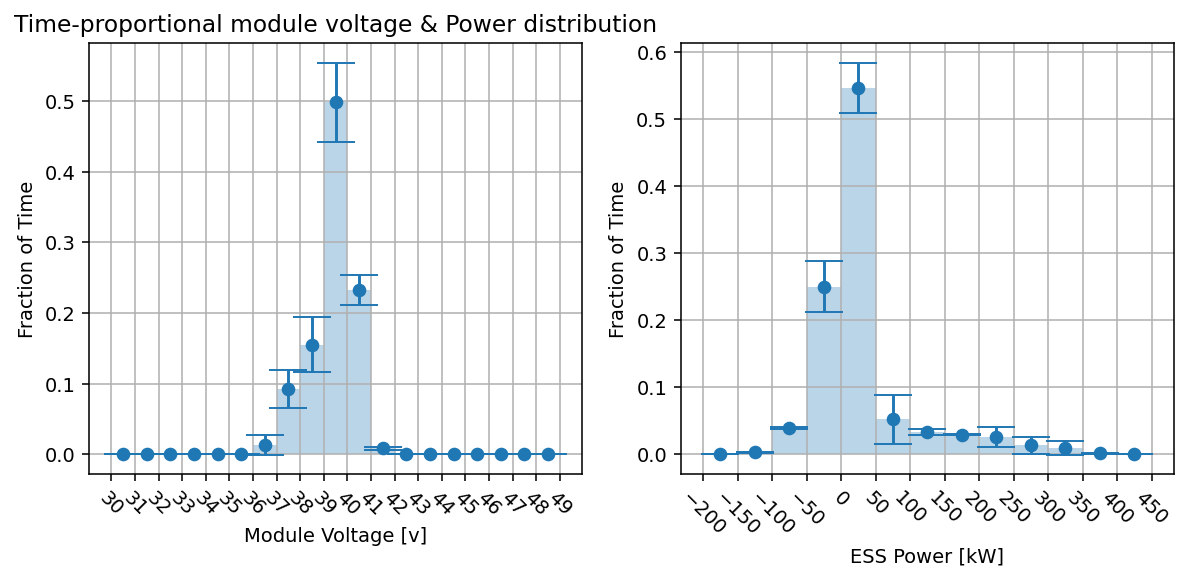


Route 118 Inbound: 
	Milage Min: 0.3361 kWh, Max: 1.7573 kWh, Average Mean: 0.5556+/-0.0918 kWh, Average STD: 0.1203+/-0.0465 kWh
	Time Min: 512.6842 s, Max: 3238.2611 s, Average Mean: 1556.2577+/-427.3308 s, Average STD: 262.6897+/-64.8171 s


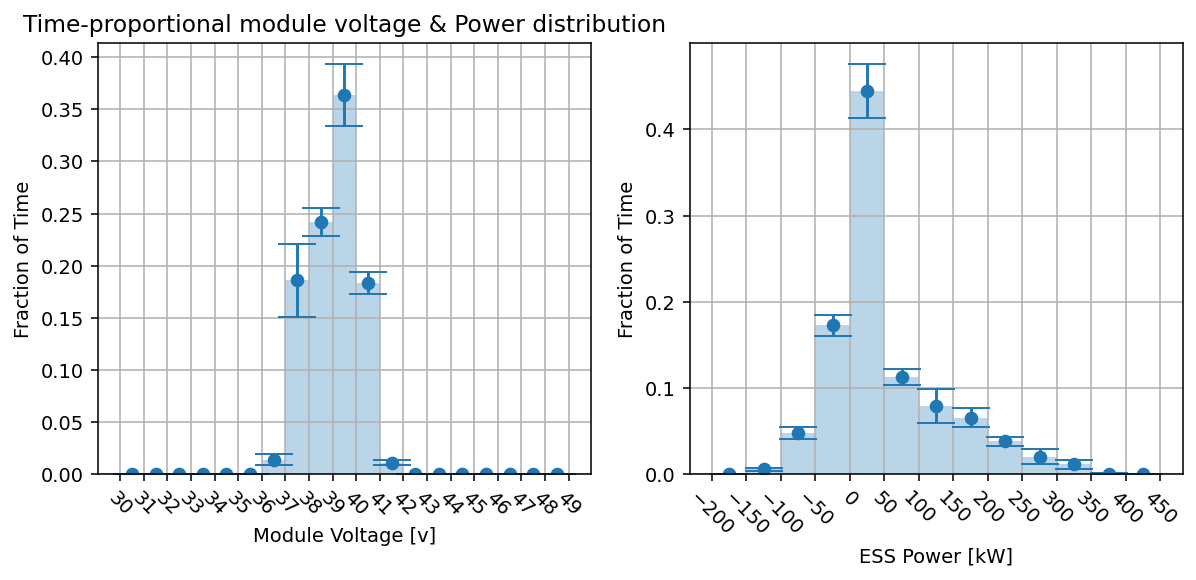

Route 118 Outbound: 
	Milage Min: 0.2688 kWh, Max: 0.7932 kWh, Average Mean: 0.4592+/-0.0522 kWh, Average STD: 0.079+/-0.0177 kWh
	Time Min: 487.0717 s, Max: 3423.5925 s, Average Mean: 1623.2506+/-435.0351 s, Average STD: 284.2877+/-69.3287 s


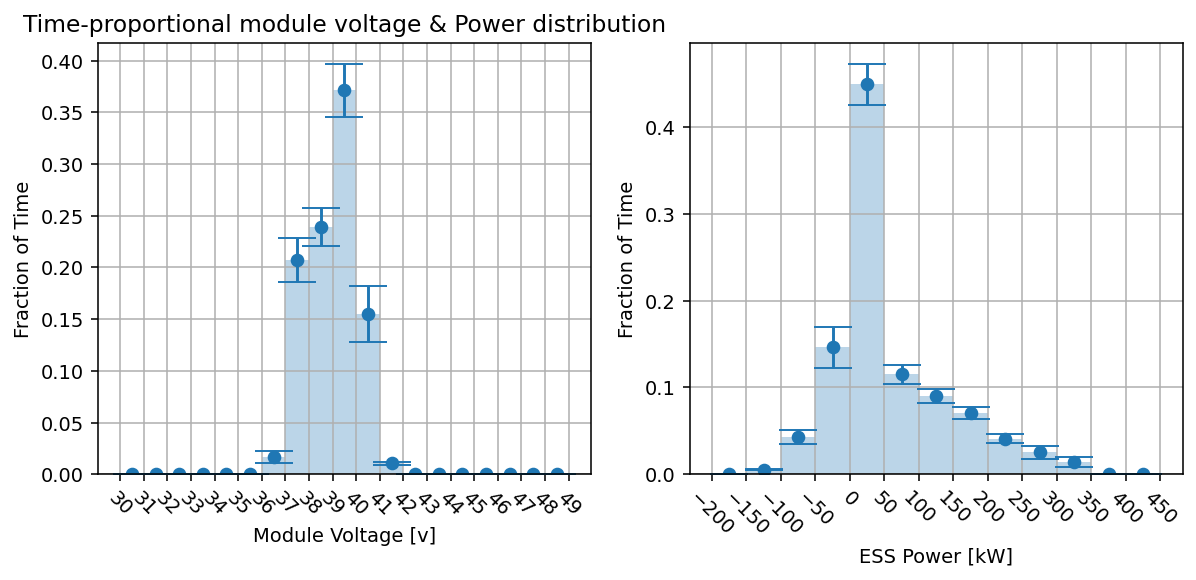


Route 11 Inbound: 
	Milage Min: 0.1511 kWh, Max: 0.3175 kWh, Average Mean: 0.2191+/-0.0113 kWh, Average STD: 0.0299+/-0.0045 kWh
	Time Min: 754.4237 s, Max: 3451.4077 s, Average Mean: 1705.8227+/-330.8135 s, Average STD: 402.6774+/-63.9463 s


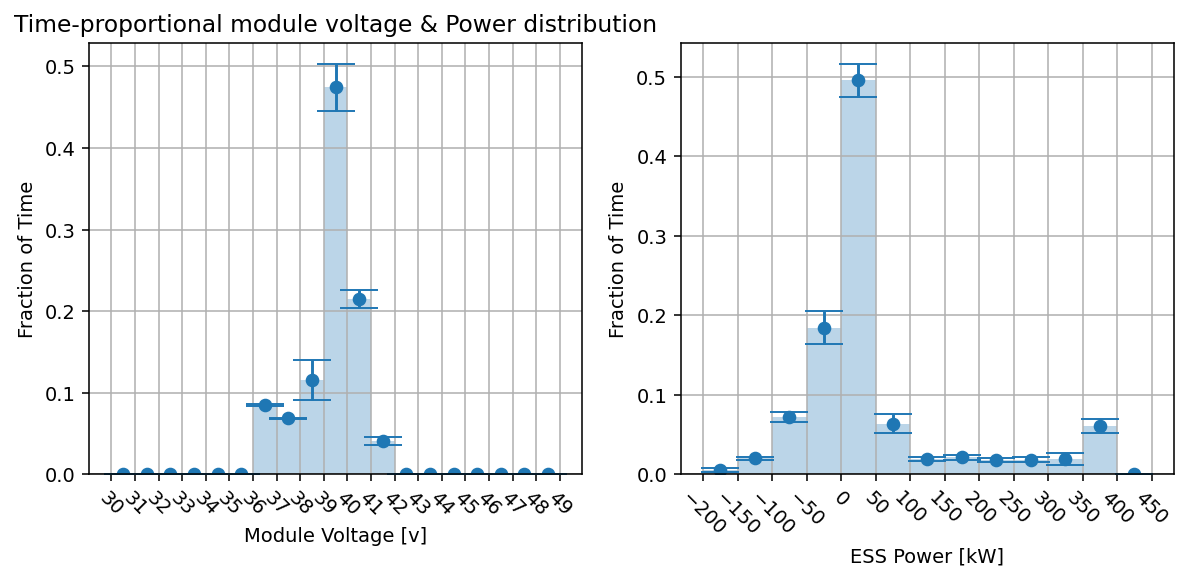

Route 11 Outbound: 
	Milage Min: 0.154 kWh, Max: 0.3489 kWh, Average Mean: 0.2241+/-0.0203 kWh, Average STD: 0.0323+/-0.006 kWh
	Time Min: 901.8935 s, Max: 3153.5609 s, Average Mean: 1766.261+/-318.7781 s, Average STD: 392.4123+/-45.7595 s


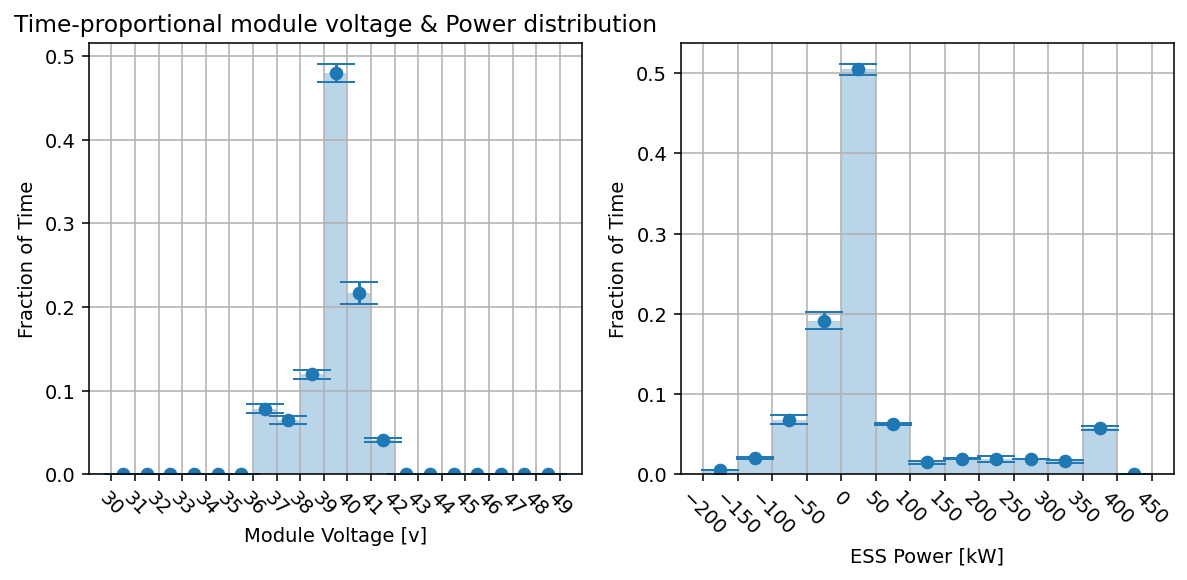


Route 124 Inbound: 
	Milage Min: 0.1813 kWh, Max: 0.5518 kWh, Average Mean: 0.3072+/-0.0375 kWh, Average STD: 0.0512+/-0.0076 kWh
	Time Min: 1687.1607 s, Max: 6525.0957 s, Average Mean: 3591.2791+/-278.2197 s, Average STD: 714.7081+/-41.4889 s


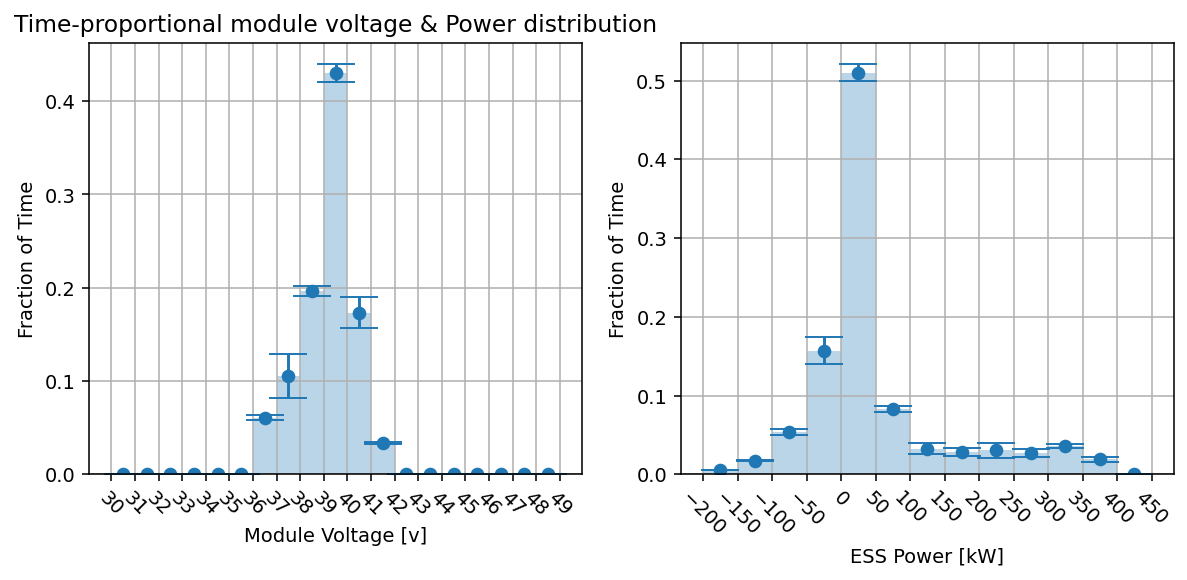

Route 124 Outbound: 
	Milage Min: 0.1871 kWh, Max: 0.6535 kWh, Average Mean: 0.3046+/-0.0374 kWh, Average STD: 0.05+/-0.0096 kWh
	Time Min: 1806.7805 s, Max: 5970.6456 s, Average Mean: 3474.7886+/-312.3871 s, Average STD: 630.0184+/-39.342 s


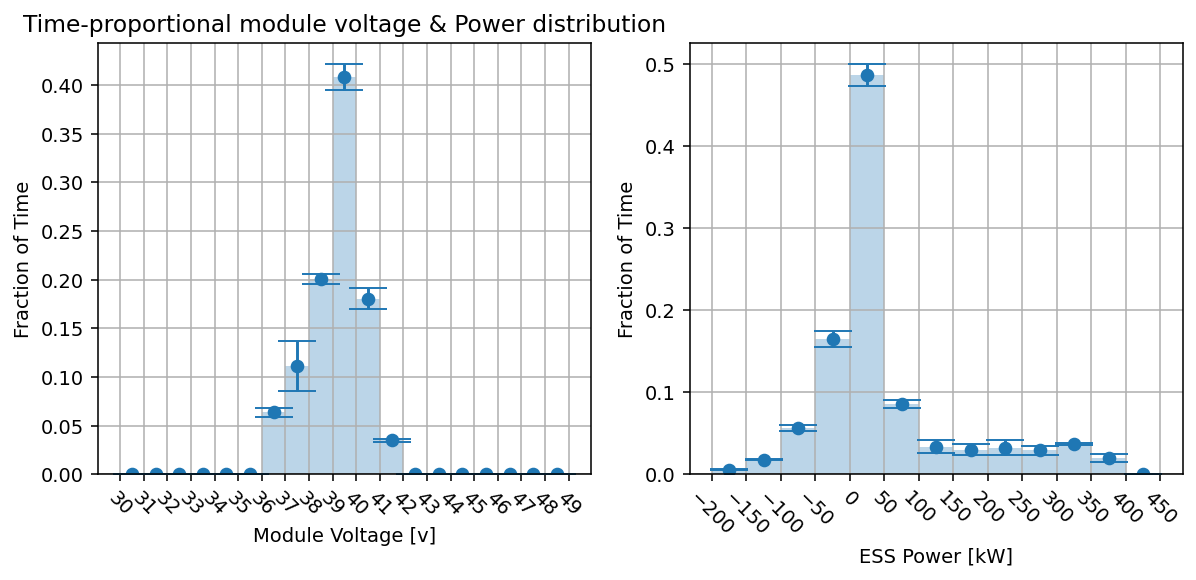


Route 131 Inbound: 
	Milage Min: 0.1918 kWh, Max: 0.441 kWh, Average Mean: 0.2826+/-0.0062 kWh, Average STD: 0.048+/-0.0011 kWh
	Time Min: 1863.9738 s, Max: 6478.8443 s, Average Mean: 3735.5669+/-318.4238 s, Average STD: 761.8909+/-36.542 s


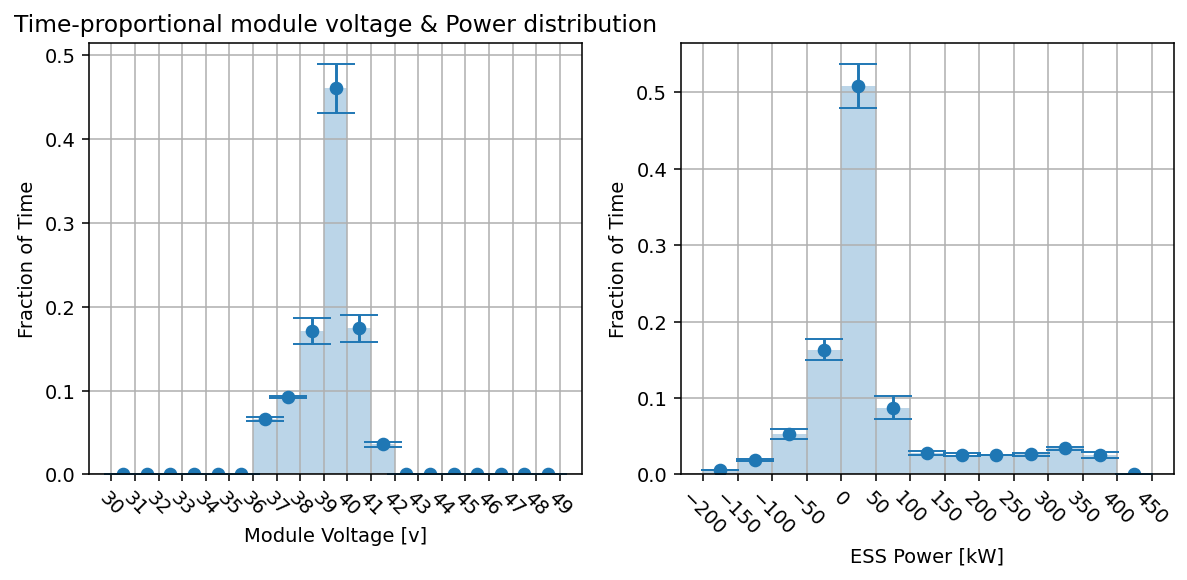

Route 131 Outbound: 
	Milage Min: 0.1735 kWh, Max: 0.525 kWh, Average Mean: 0.2838+/-0.0161 kWh, Average STD: 0.0495+/-0.0043 kWh
	Time Min: 1849.3922 s, Max: 6804.3544 s, Average Mean: 3905.769+/-354.5023 s, Average STD: 810.8706+/-57.8738 s


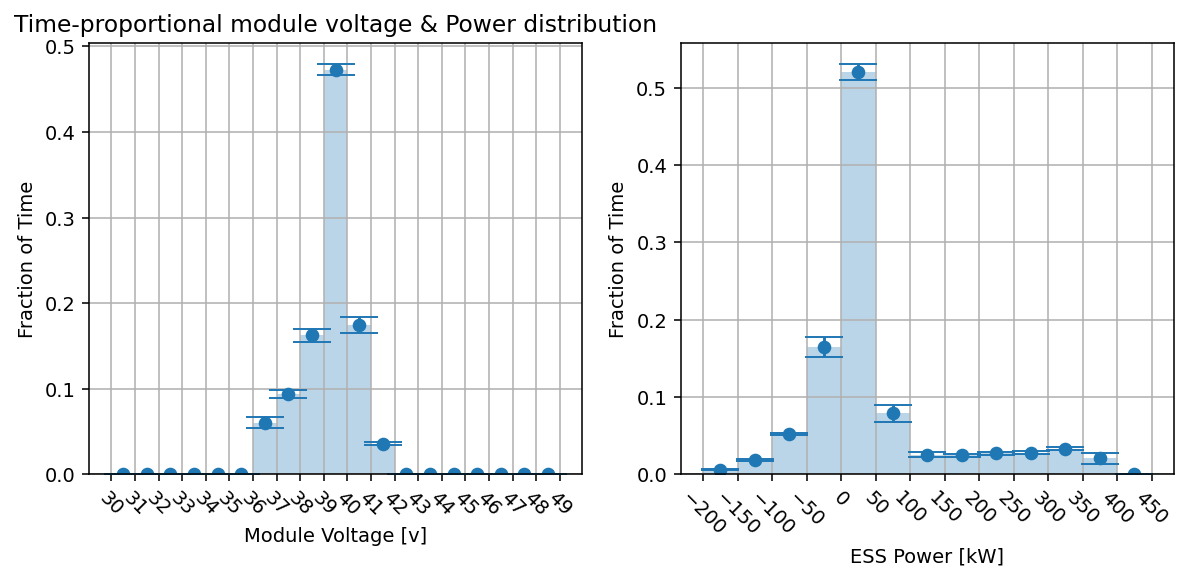


Route 132 Inbound: 
	Milage Min: 0.1797 kWh, Max: 0.3642 kWh, Average Mean: 0.2553+/-0.0048 kWh, Average STD: 0.0399+/-0.0001 kWh
	Time Min: 1984.2512 s, Max: 6726.4398 s, Average Mean: 3964.3226+/-452.15 s, Average STD: 852.687+/-43.0757 s


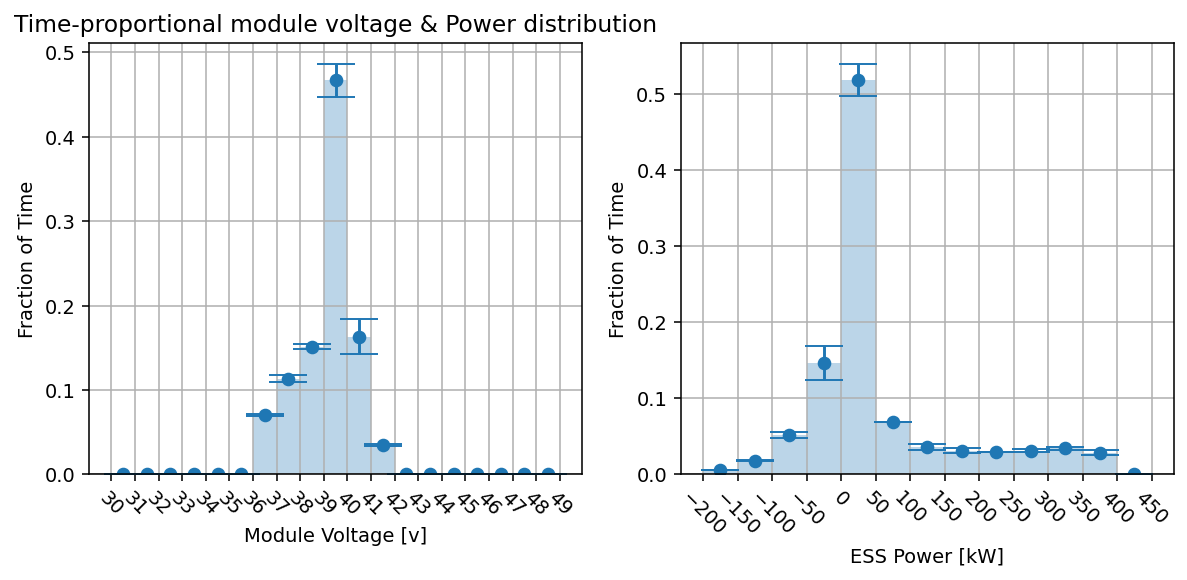

Route 132 Outbound: 
	Milage Min: 0.1982 kWh, Max: 0.5547 kWh, Average Mean: 0.3028+/-0.0208 kWh, Average STD: 0.0525+/-0.0065 kWh
	Time Min: 2177.8082 s, Max: 7249.9508 s, Average Mean: 4104.9334+/-504.4044 s, Average STD: 892.2504+/-94.6696 s


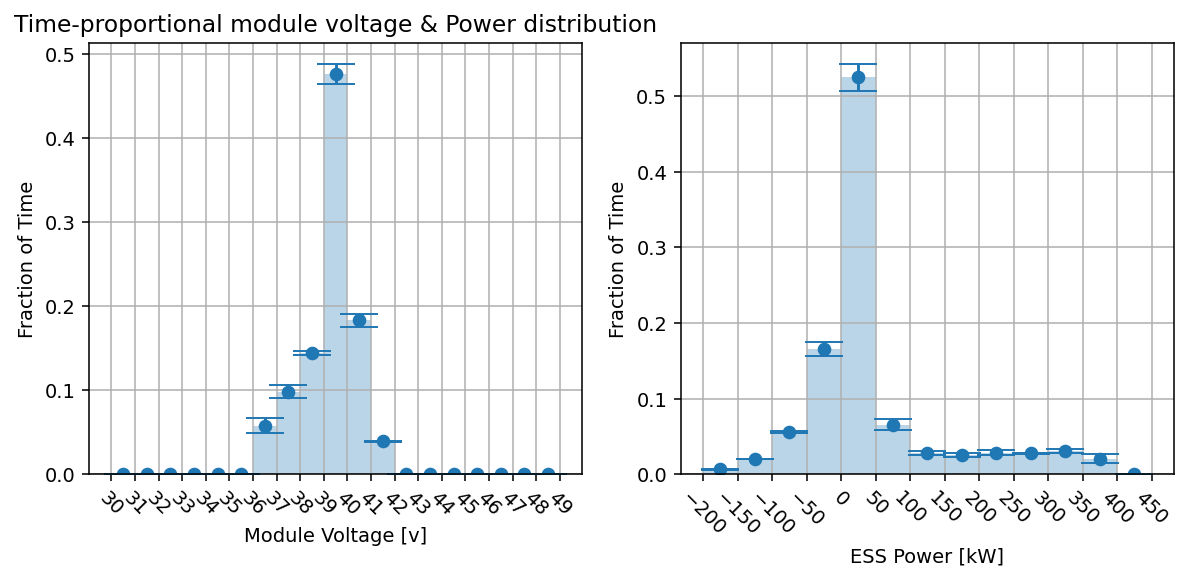


Route 14 Inbound: 
	Milage Min: 0.2023 kWh, Max: 0.5599 kWh, Average Mean: 0.3203+/-0.0222 kWh, Average STD: 0.05+/-0.0082 kWh
	Time Min: 752.1202 s, Max: 3197.0305 s, Average Mean: 1675.7276+/-248.6954 s, Average STD: 359.5426+/-32.3396 s


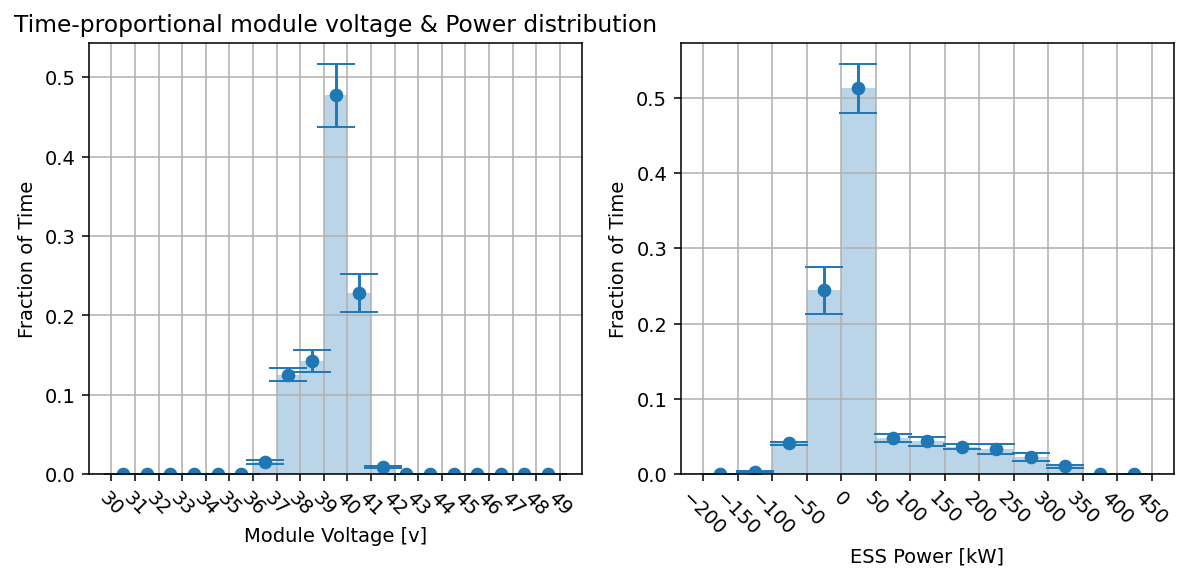

Route 14 Outbound: 
	Milage Min: 0.1923 kWh, Max: 0.5344 kWh, Average Mean: 0.312+/-0.0214 kWh, Average STD: 0.0501+/-0.005 kWh
	Time Min: 751.1826 s, Max: 4293.7423 s, Average Mean: 1902.1241+/-407.9501 s, Average STD: 434.4892+/-93.5078 s


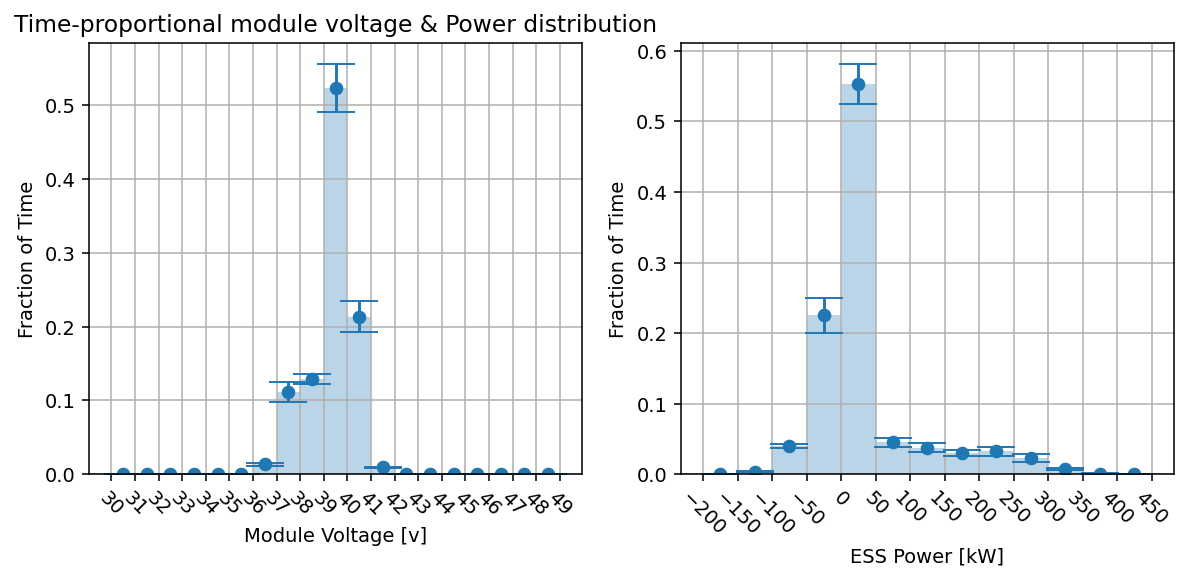


Route 150 Inbound: 
	Milage Min: 0.2445 kWh, Max: 0.5417 kWh, Average Mean: 0.3452+/-0.0095 kWh, Average STD: 0.0506+/-0.0048 kWh
	Time Min: 2987.6307 s, Max: 7036.9914 s, Average Mean: 4768.2124+/-211.4011 s, Average STD: 809.2656+/-62.7965 s


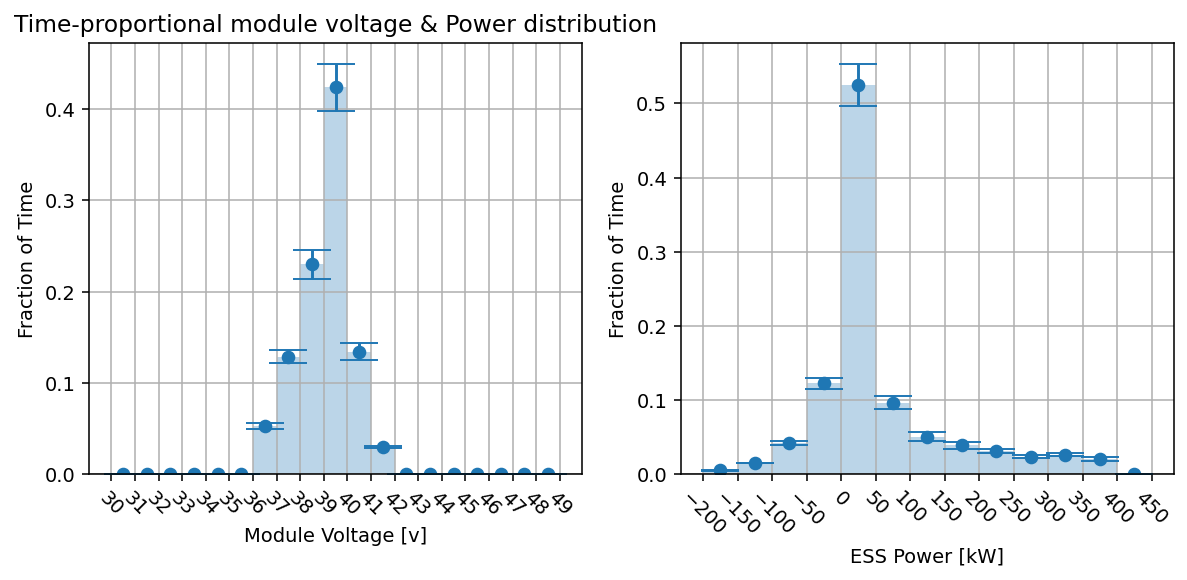

Route 150 Outbound: 
	Milage Min: 0.2462 kWh, Max: 0.5353 kWh, Average Mean: 0.3461+/-0.0107 kWh, Average STD: 0.051+/-0.0041 kWh
	Time Min: 2968.7399 s, Max: 7133.9831 s, Average Mean: 4627.8119+/-314.8977 s, Average STD: 757.9829+/-104.9597 s


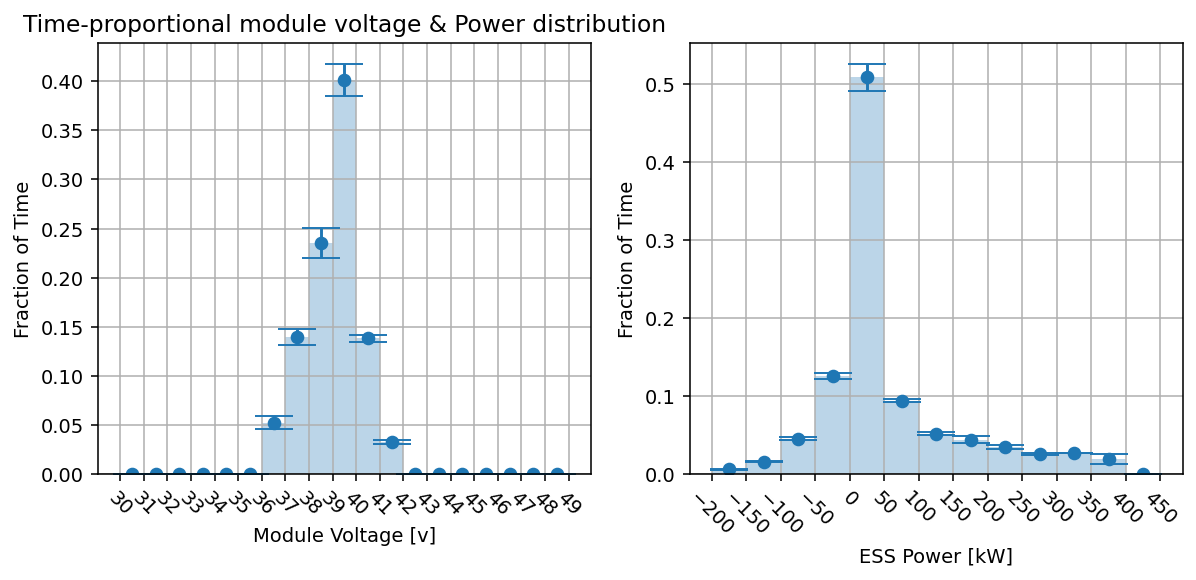


Route 1 Inbound: 
	Milage Min: 0.1611 kWh, Max: 0.6544 kWh, Average Mean: 0.2996+/-0.0643 kWh, Average STD: 0.0519+/-0.0158 kWh
	Time Min: 639.6269 s, Max: 3703.6012 s, Average Mean: 1853.8373+/-333.3358 s, Average STD: 462.5734+/-44.0948 s


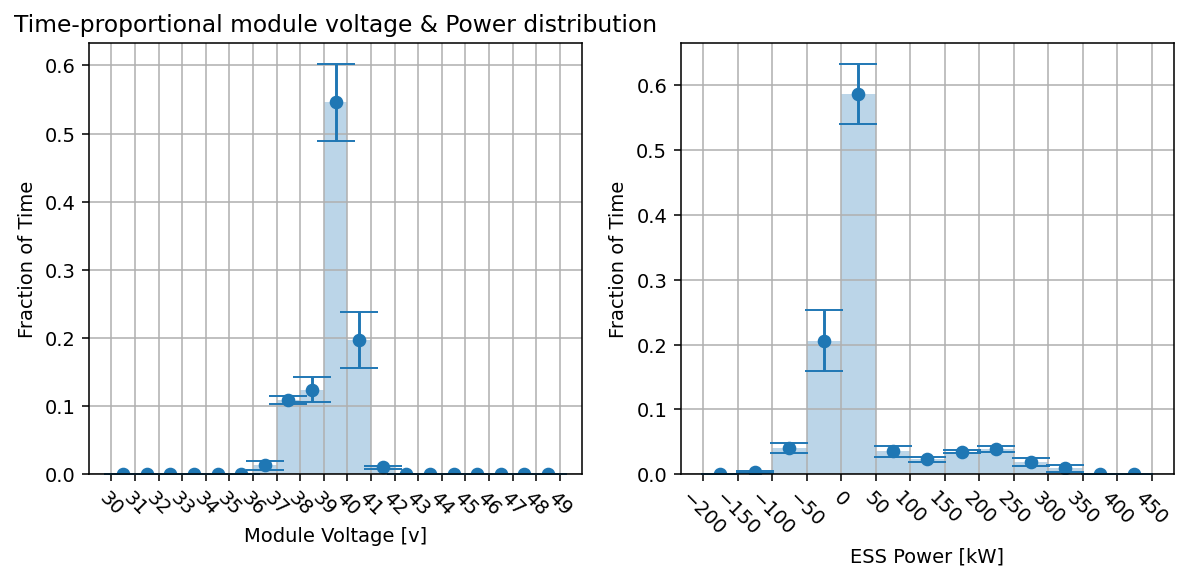

Route 1 Outbound: 
	Milage Min: 0.1795 kWh, Max: 0.6734 kWh, Average Mean: 0.318+/-0.0647 kWh, Average STD: 0.0572+/-0.022 kWh
	Time Min: 656.5427 s, Max: 3780.3848 s, Average Mean: 1782.3239+/-407.5683 s, Average STD: 404.9416+/-82.0168 s


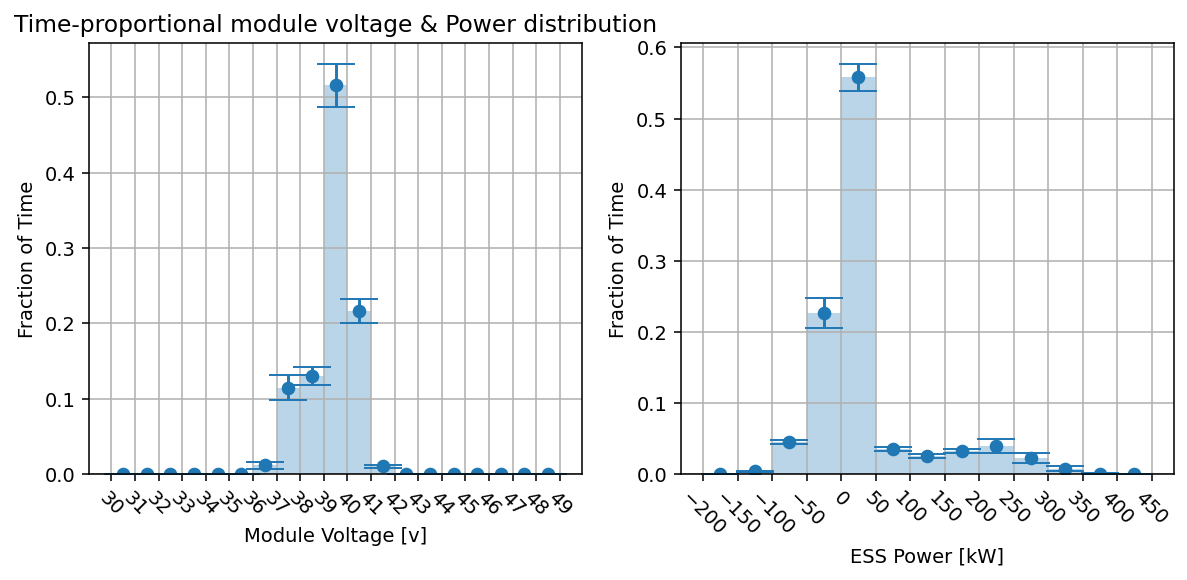


Route 21 Inbound: 
	Milage Min: 0.1605 kWh, Max: 0.4513 kWh, Average Mean: 0.2458+/-0.0268 kWh, Average STD: 0.0377+/-0.0064 kWh
	Time Min: 1450.7217 s, Max: 6131.2775 s, Average Mean: 3279.1219+/-361.1765 s, Average STD: 734.8276+/-60.624 s


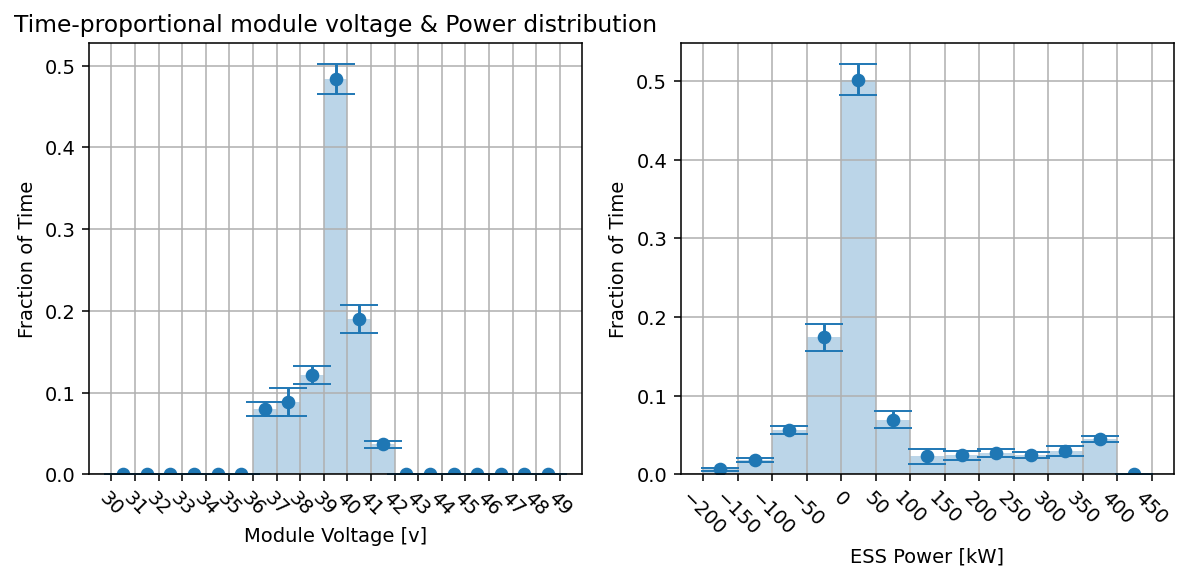

Route 21 Outbound: 
	Milage Min: 0.1727 kWh, Max: 0.4562 kWh, Average Mean: 0.2562+/-0.0237 kWh, Average STD: 0.0392+/-0.0048 kWh
	Time Min: 1423.499 s, Max: 6110.8437 s, Average Mean: 3145.7167+/-439.6804 s, Average STD: 683.5382+/-94.4408 s


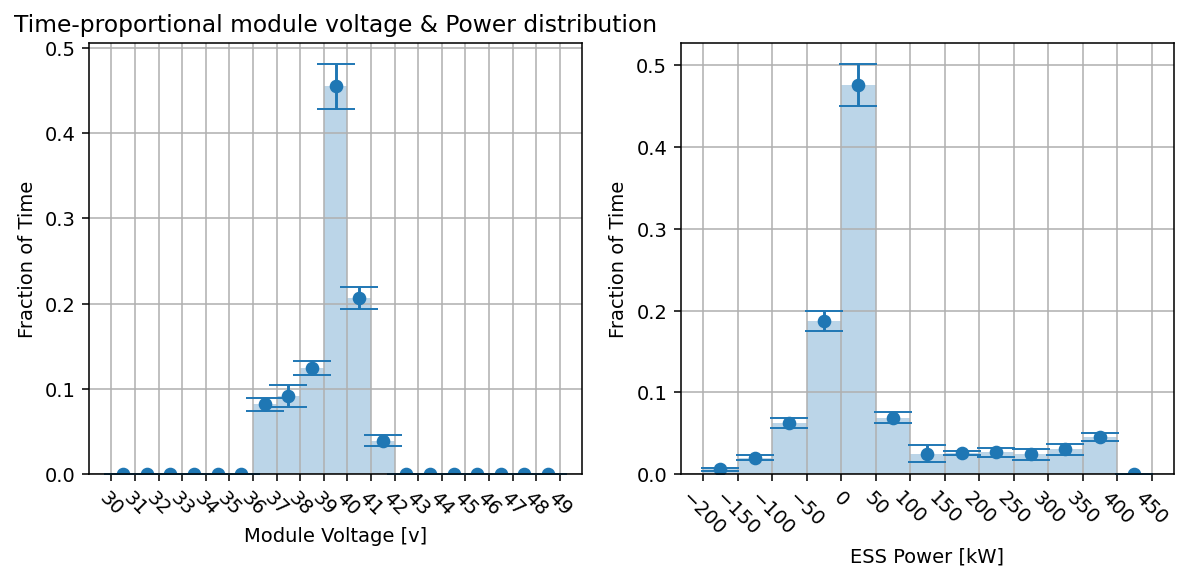


Route 24 Inbound: 
	Milage Min: 0.1648 kWh, Max: 0.4868 kWh, Average Mean: 0.271+/-0.027 kWh, Average STD: 0.0484+/-0.0086 kWh
	Time Min: 943.934 s, Max: 6220.7923 s, Average Mean: 2841.1321+/-422.0577 s, Average STD: 757.3198+/-97.9161 s


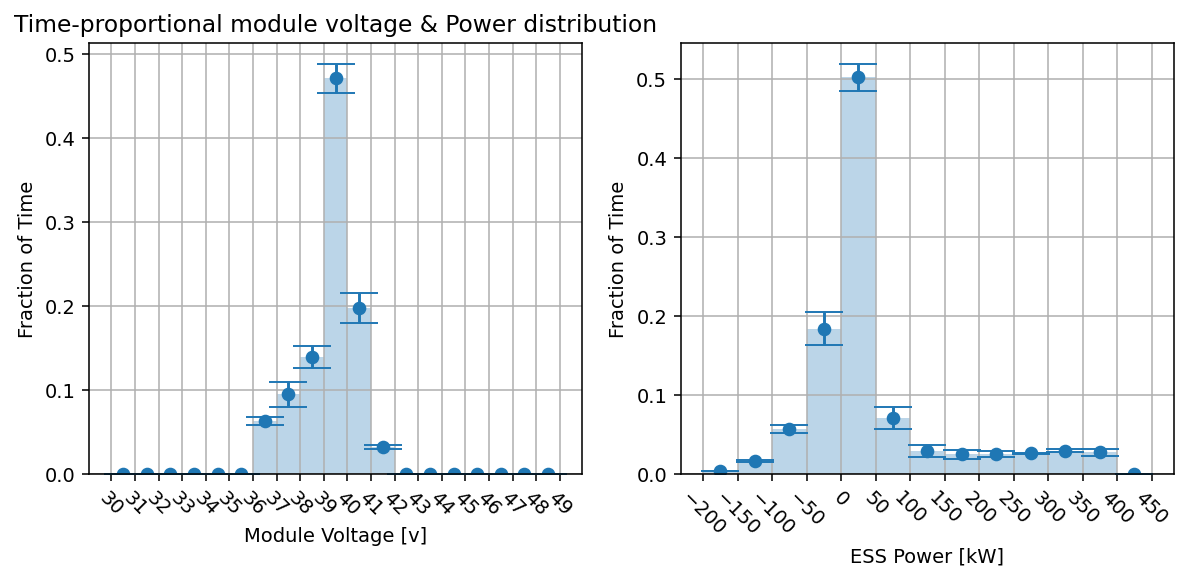

Route 24 Outbound: 
	Milage Min: 0.161 kWh, Max: 0.4676 kWh, Average Mean: 0.2607+/-0.0312 kWh, Average STD: 0.0455+/-0.0118 kWh
	Time Min: 1126.7527 s, Max: 5861.2951 s, Average Mean: 2932.297+/-448.0373 s, Average STD: 692.2728+/-101.6421 s


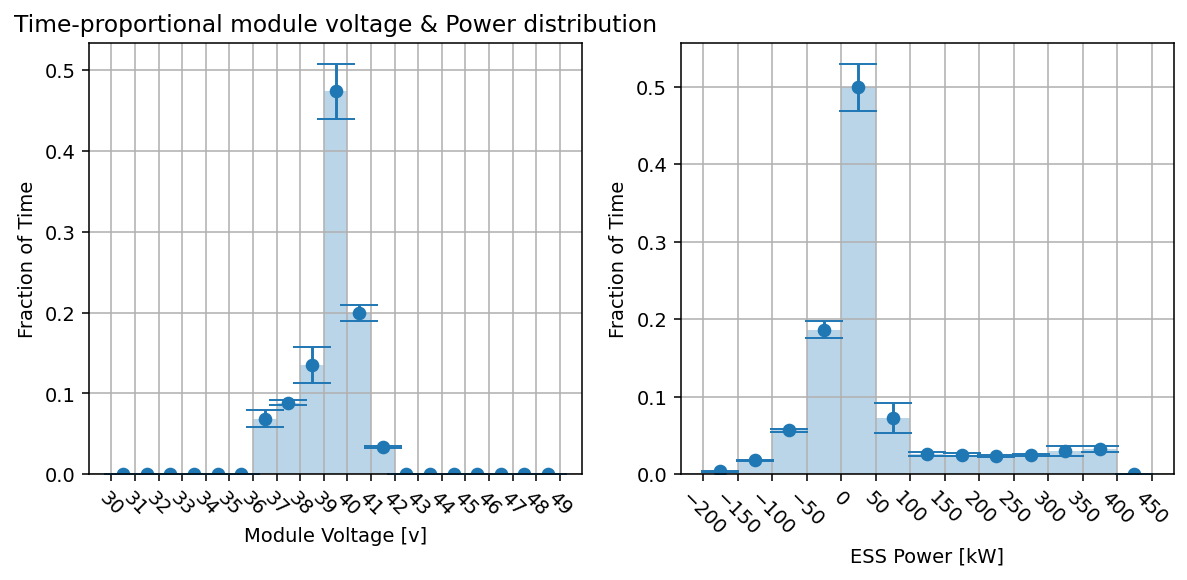


Route 27 Inbound: 
	Milage Min: 0.1532 kWh, Max: 0.349 kWh, Average Mean: 0.218+/-0.0082 kWh, Average STD: 0.0283+/-0.0028 kWh
	Time Min: 620.0287 s, Max: 3387.5758 s, Average Mean: 1612.7328+/-312.9269 s, Average STD: 404.2123+/-76.2576 s


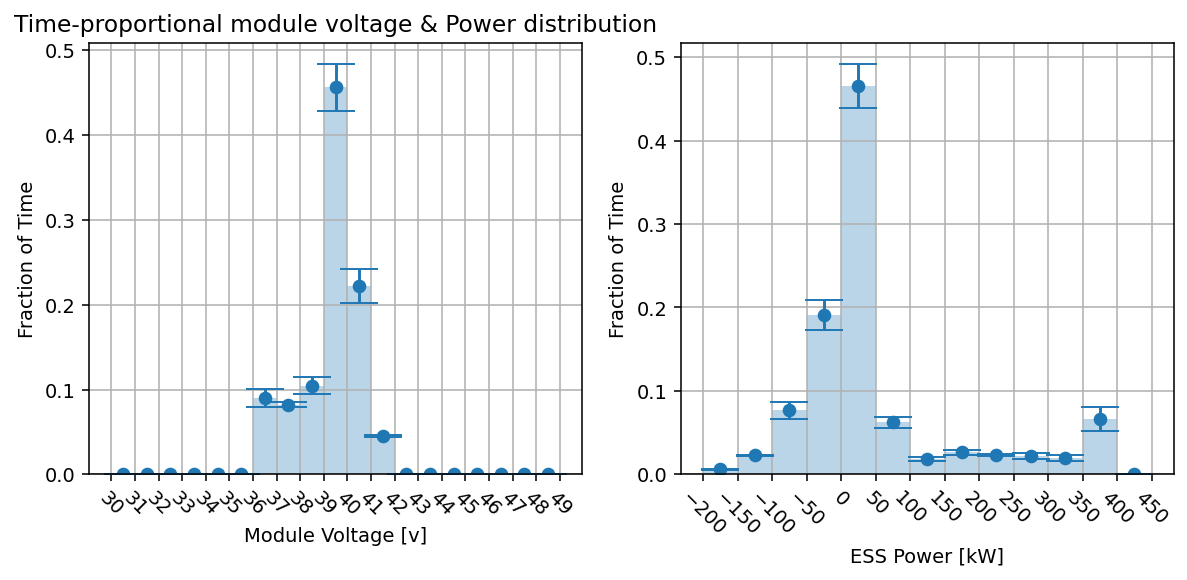

Route 27 Outbound: 
	Milage Min: 0.1522 kWh, Max: 0.3417 kWh, Average Mean: 0.2199+/-0.0078 kWh, Average STD: 0.0292+/-0.0036 kWh
	Time Min: 667.3239 s, Max: 3479.2338 s, Average Mean: 1704.5807+/-285.4459 s, Average STD: 425.9743+/-65.3066 s


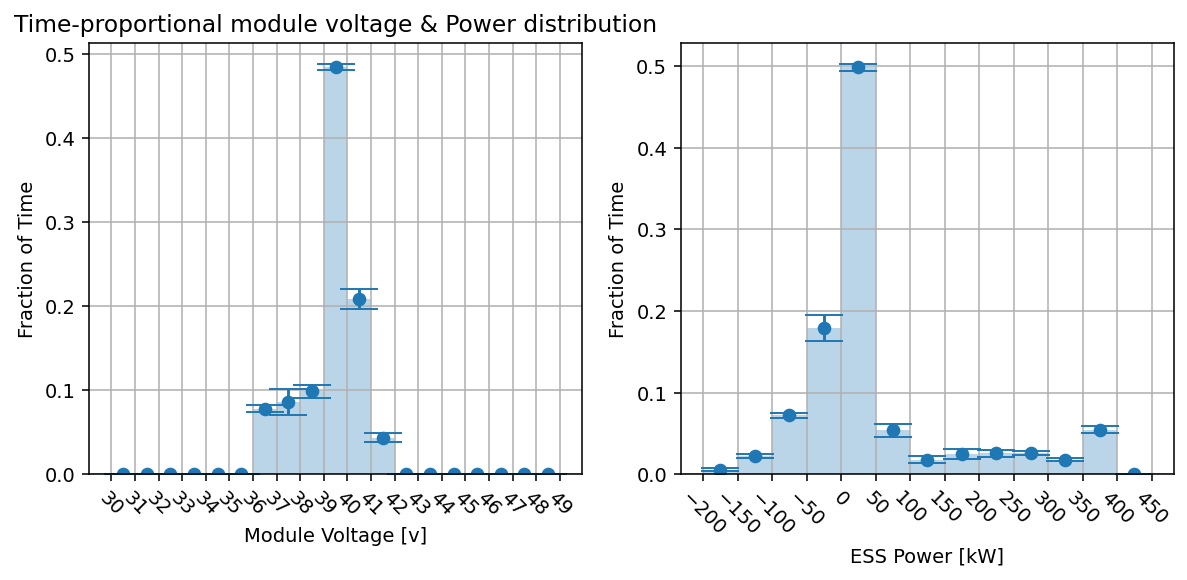


Route 28 Inbound: 
	Milage Min: 0.1758 kWh, Max: 0.4587 kWh, Average Mean: 0.2818+/-0.0394 kWh, Average STD: 0.05+/-0.0115 kWh
	Time Min: 987.52 s, Max: 4040.1253 s, Average Mean: 2255.6169+/-527.0435 s, Average STD: 460.7033+/-59.8563 s


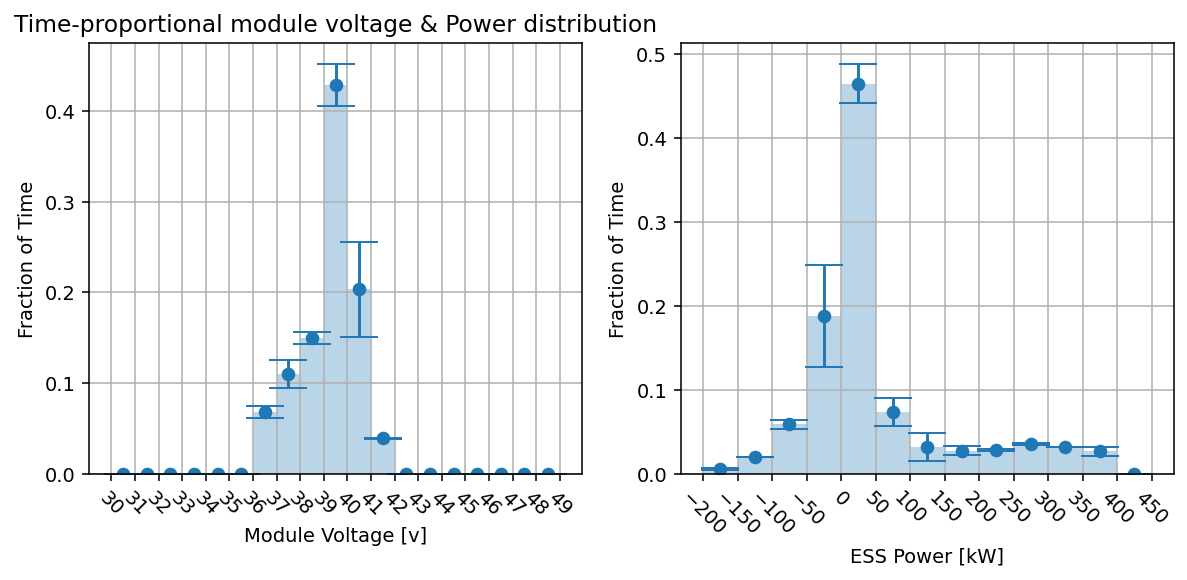

Route 28 Outbound: 
	Milage Min: 0.1649 kWh, Max: 0.4662 kWh, Average Mean: 0.2711+/-0.0532 kWh, Average STD: 0.0473+/-0.0174 kWh
	Time Min: 1119.3552 s, Max: 4671.0972 s, Average Mean: 2207.4227+/-797.142 s, Average STD: 408.8176+/-197.3992 s


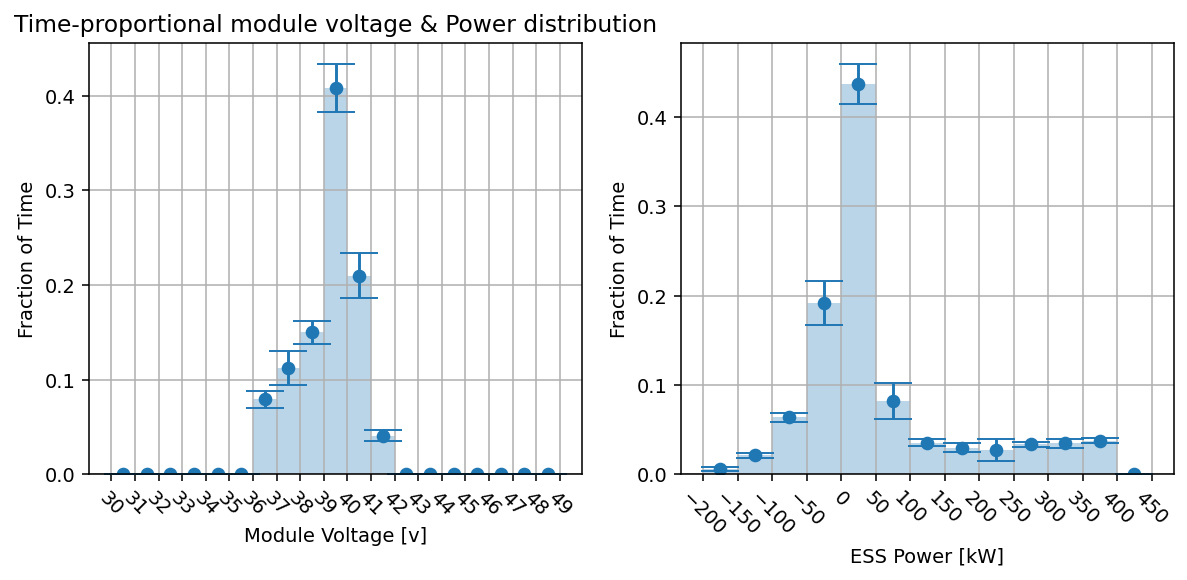


Route 33 Inbound: 
	Milage Min: 0.1632 kWh, Max: 0.436 kWh, Average Mean: 0.2717+/-0.0167 kWh, Average STD: 0.0475+/-0.0036 kWh
	Time Min: 881.9531 s, Max: 4869.1952 s, Average Mean: 2464.0586+/-381.1041 s, Average STD: 585.9668+/-52.462 s


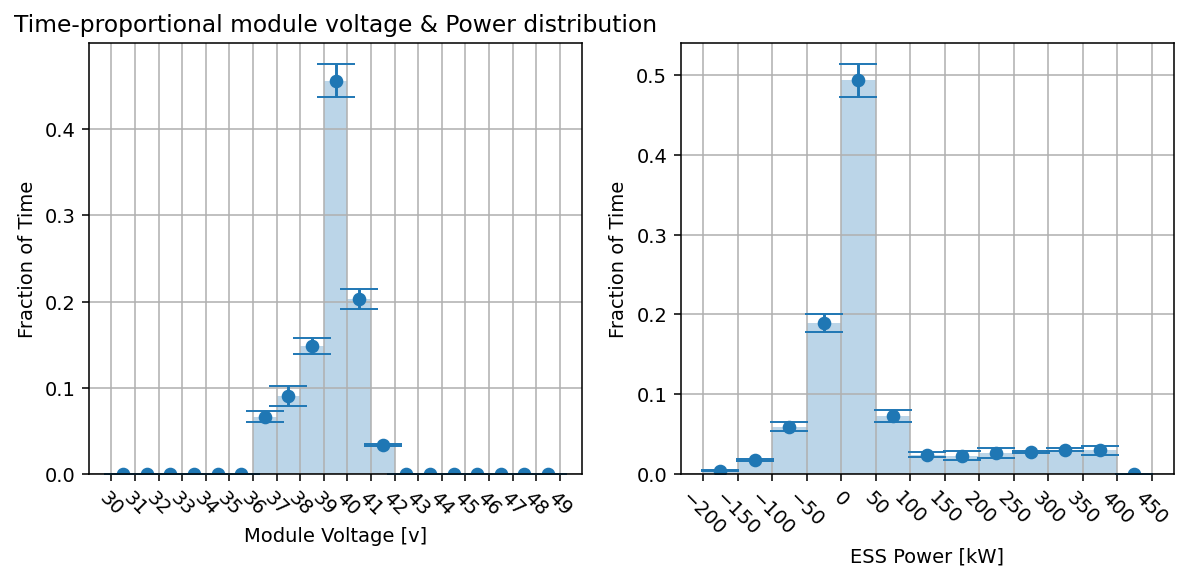

Route 33 Outbound: 
	Milage Min: 0.1628 kWh, Max: 0.4005 kWh, Average Mean: 0.2564+/-0.006 kWh, Average STD: 0.0419+/-0.0043 kWh
	Time Min: 947.3961 s, Max: 5101.7779 s, Average Mean: 2569.0677+/-494.1758 s, Average STD: 581.1586+/-99.9708 s


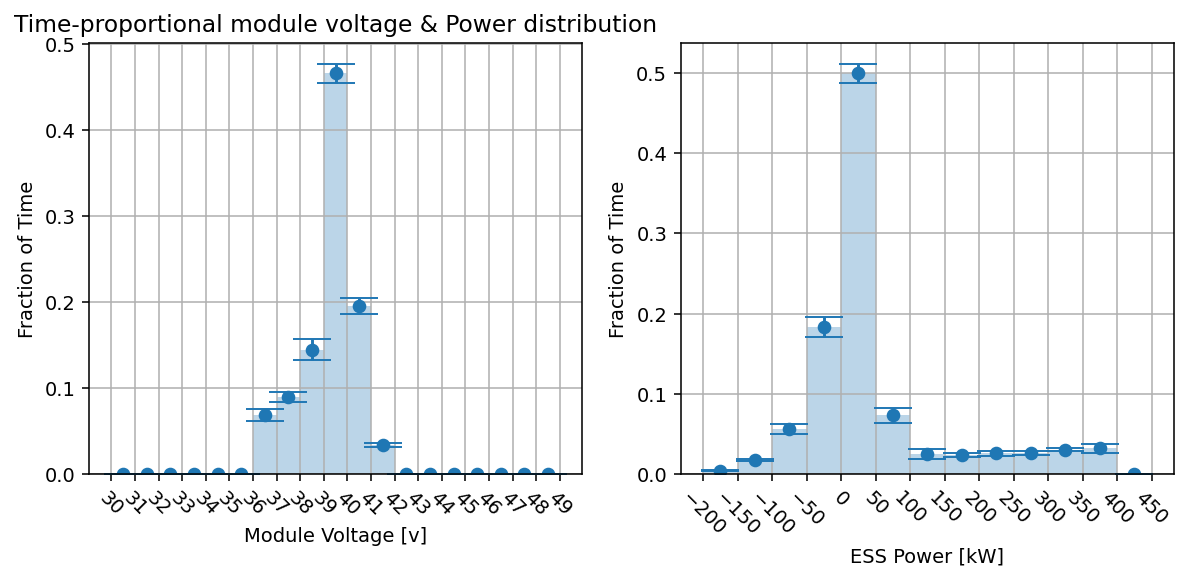


Route 345 Inbound: 
	Milage Min: 0.2544 kWh, Max: 0.628 kWh, Average Mean: 0.4178+/-0.0272 kWh, Average STD: 0.0626+/-0.008 kWh
	Time Min: 1220.3757 s, Max: 3904.7793 s, Average Mean: 2184.3112+/-2.7962 s, Average STD: 484.3716+/-16.0242 s


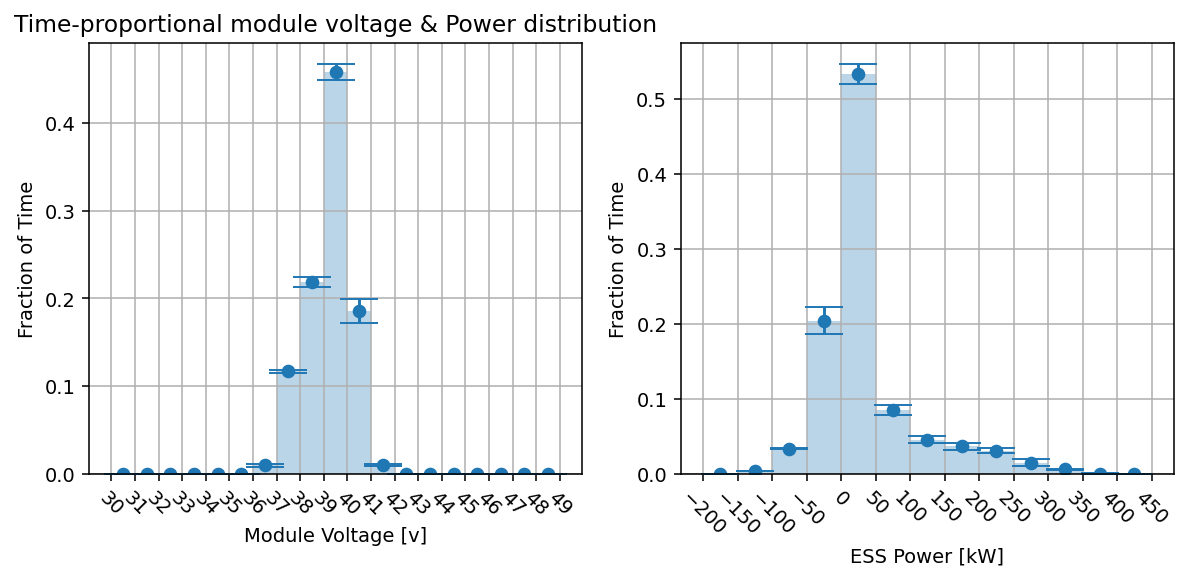

Route 345 Outbound: 
	Milage Min: 0.2712 kWh, Max: 0.5977 kWh, Average Mean: 0.4003+/-0.0277 kWh, Average STD: 0.0599+/-0.0052 kWh
	Time Min: 1400.8416 s, Max: 3890.9512 s, Average Mean: 2351.064+/-25.3897 s, Average STD: 510.9276+/-1.9623 s


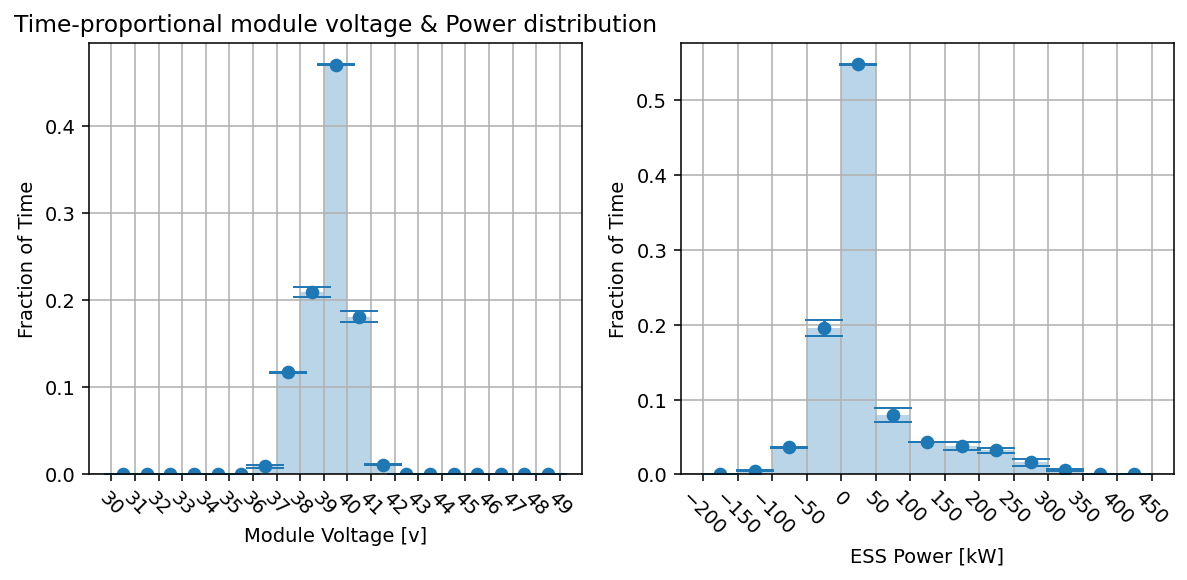


Route 346 Inbound: 
	Milage Min: 0.2109 kWh, Max: 0.6726 kWh, Average Mean: 0.3726+/-0.0416 kWh, Average STD: 0.0729+/-0.0123 kWh
	Time Min: 516.265 s, Max: 2575.5681 s, Average Mean: 1194.4503+/-78.0377 s, Average STD: 346.2036+/-29.5763 s


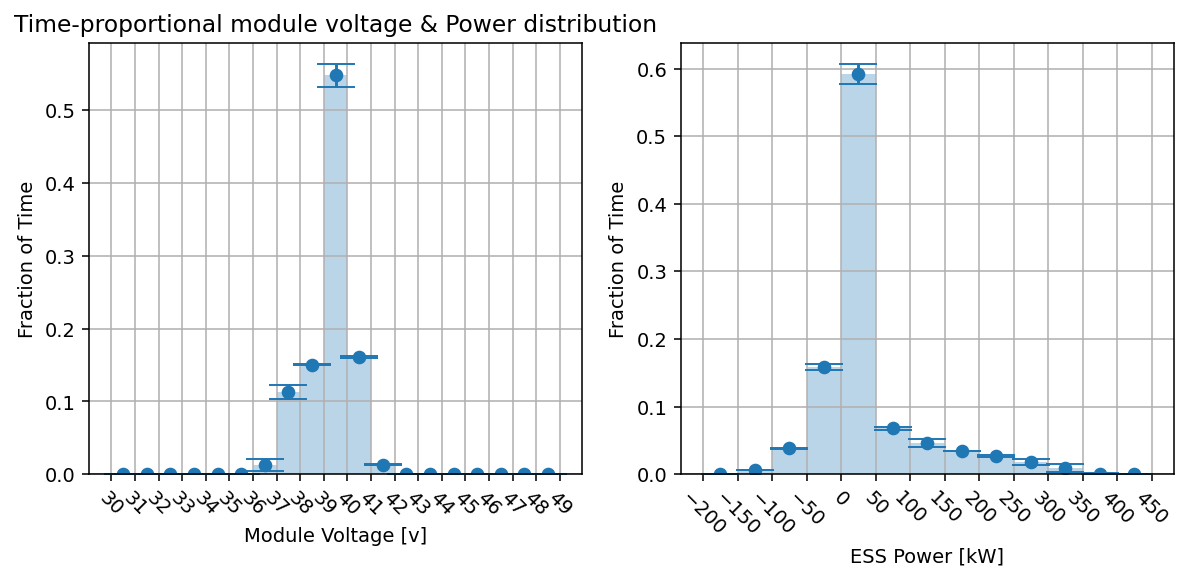

Route 346 Outbound: 
	Milage Min: 0.2216 kWh, Max: 0.5988 kWh, Average Mean: 0.3673+/-0.0285 kWh, Average STD: 0.0682+/-0.0141 kWh
	Time Min: 570.8328 s, Max: 2587.4598 s, Average Mean: 1275.3811+/-100.4797 s, Average STD: 358.3888+/-24.078 s


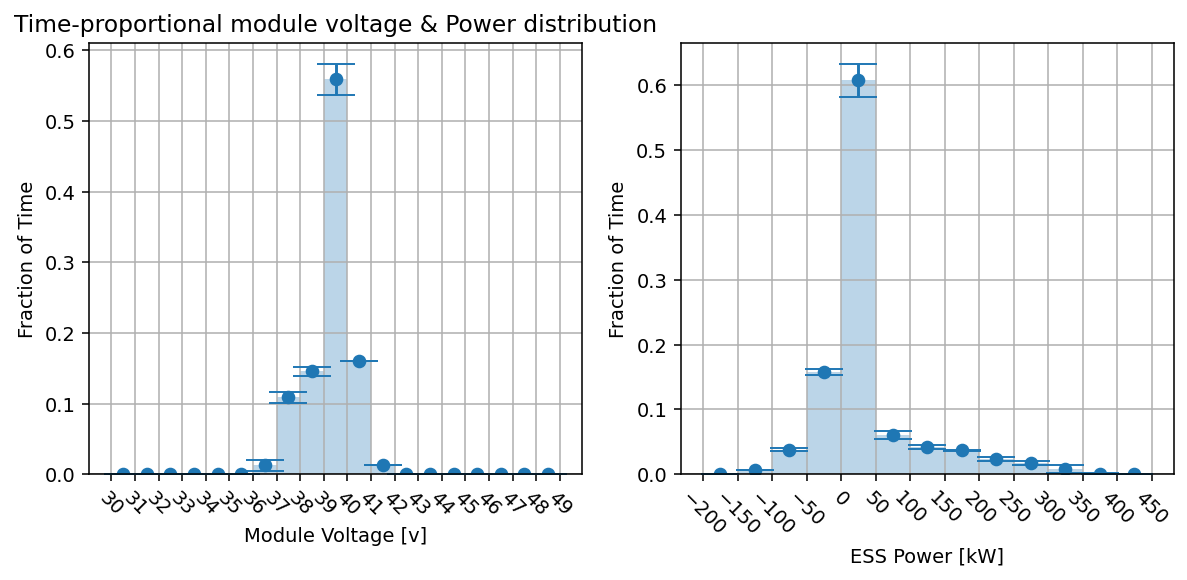


Route 348 Inbound: 
	Milage Min: 0.232 kWh, Max: 0.6903 kWh, Average Mean: 0.3996+/-0.0402 kWh, Average STD: 0.068+/-0.0129 kWh
	Time Min: 1369.8248 s, Max: 4799.6945 s, Average Mean: 2428.1287+/-118.5944 s, Average STD: 537.7147+/-35.261 s


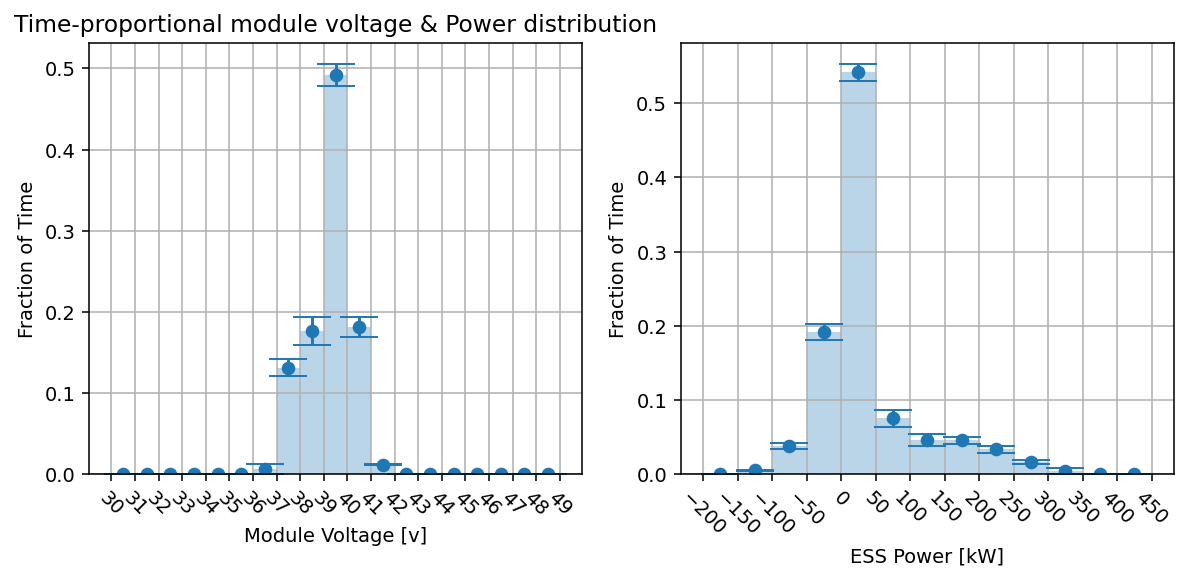

Route 348 Outbound: 
	Milage Min: 0.2387 kWh, Max: 0.6481 kWh, Average Mean: 0.3936+/-0.0449 kWh, Average STD: 0.066+/-0.013 kWh
	Time Min: 1184.817 s, Max: 3929.5937 s, Average Mean: 2336.6003+/-232.7091 s, Average STD: 454.5426+/-61.6184 s


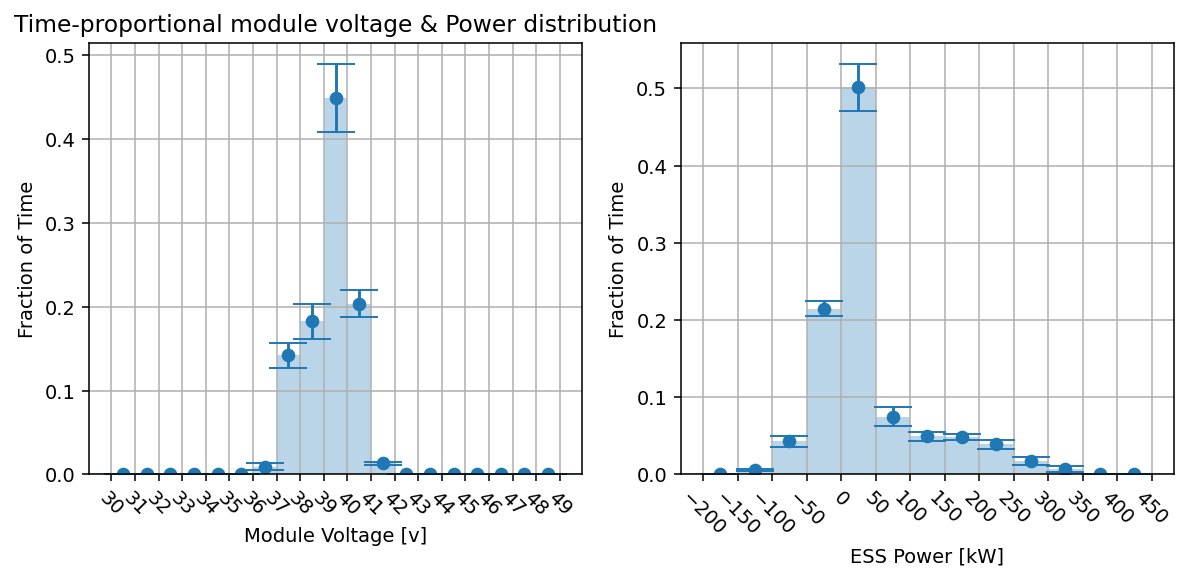


Route 36 Inbound: 
	Milage Min: 0.2088 kWh, Max: 0.544 kWh, Average Mean: 0.3299+/-0.0078 kWh, Average STD: 0.0582+/-0.0037 kWh
	Time Min: 1127.6842 s, Max: 4369.1865 s, Average Mean: 2434.2581+/-226.5017 s, Average STD: 584.6745+/-40.3161 s


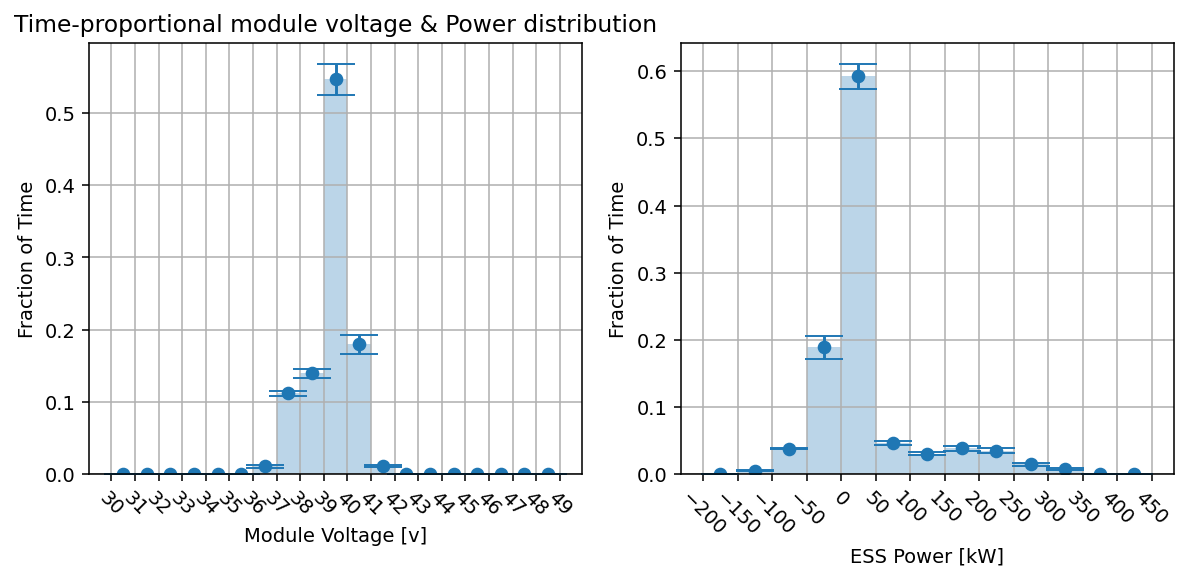

Route 36 Outbound: 
	Milage Min: 0.2144 kWh, Max: 0.5965 kWh, Average Mean: 0.332+/-0.0151 kWh, Average STD: 0.0565+/-0.004 kWh
	Time Min: 1103.0381 s, Max: 3974.4529 s, Average Mean: 2307.352+/-310.2102 s, Average STD: 482.2542+/-54.7741 s


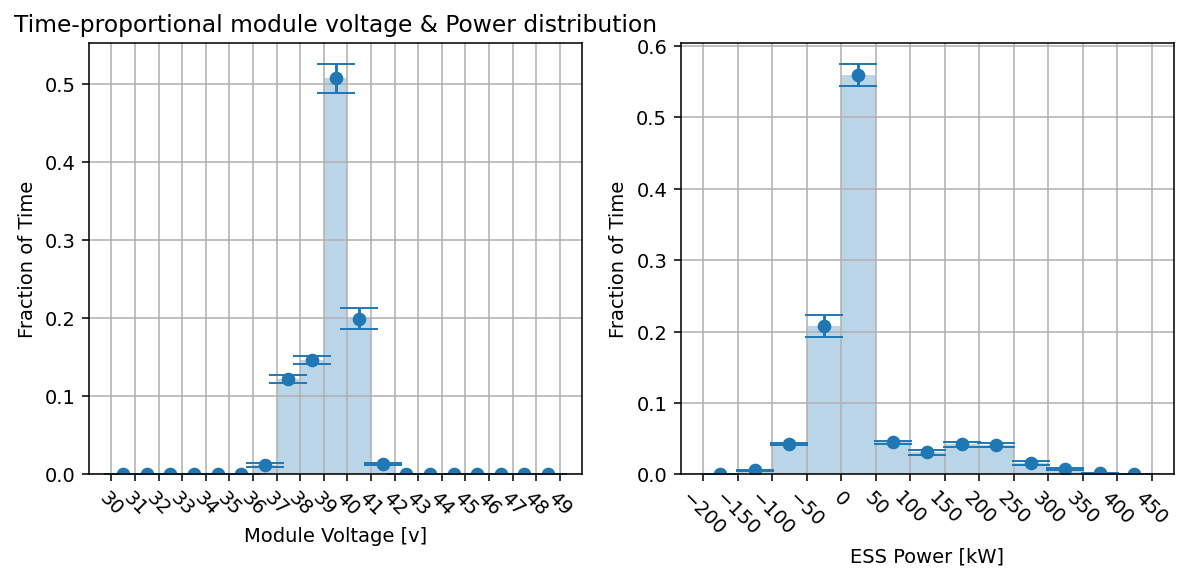


Route 3 Inbound: 
	Milage Min: 0.1592 kWh, Max: 0.6736 kWh, Average Mean: 0.292+/-0.0564 kWh, Average STD: 0.0489+/-0.0175 kWh
	Time Min: 644.3137 s, Max: 4002.6238 s, Average Mean: 1722.3251+/-457.9484 s, Average STD: 397.2571+/-116.3194 s


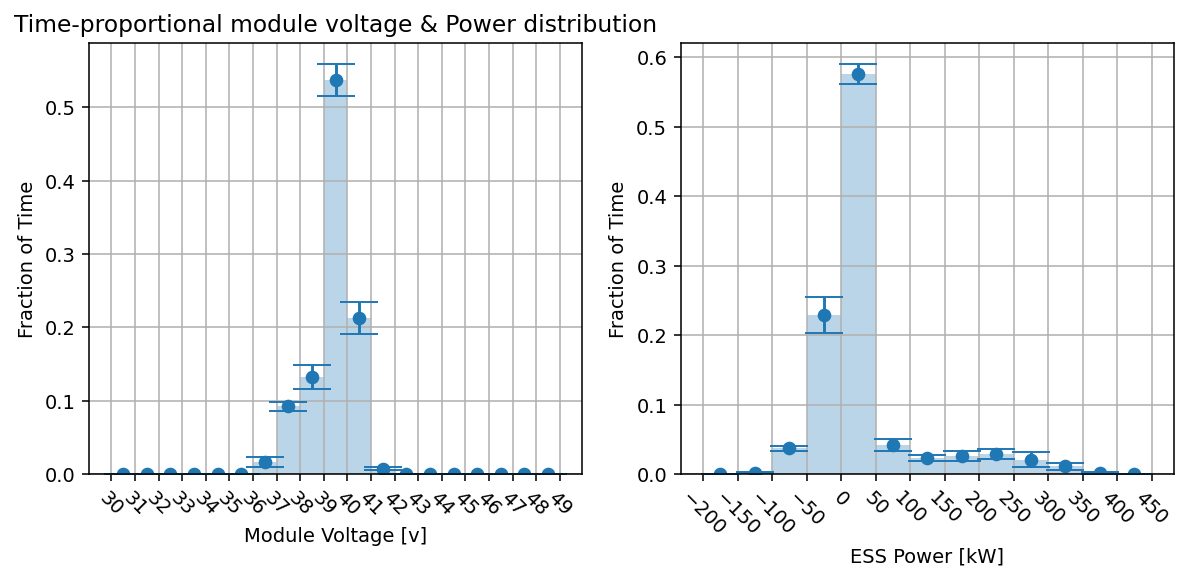

Route 3 Outbound: 
	Milage Min: 0.1593 kWh, Max: 0.8046 kWh, Average Mean: 0.2973+/-0.0608 kWh, Average STD: 0.0531+/-0.0228 kWh
	Time Min: 751.6609 s, Max: 3930.0051 s, Average Mean: 1778.014+/-457.6594 s, Average STD: 431.3047+/-115.7279 s


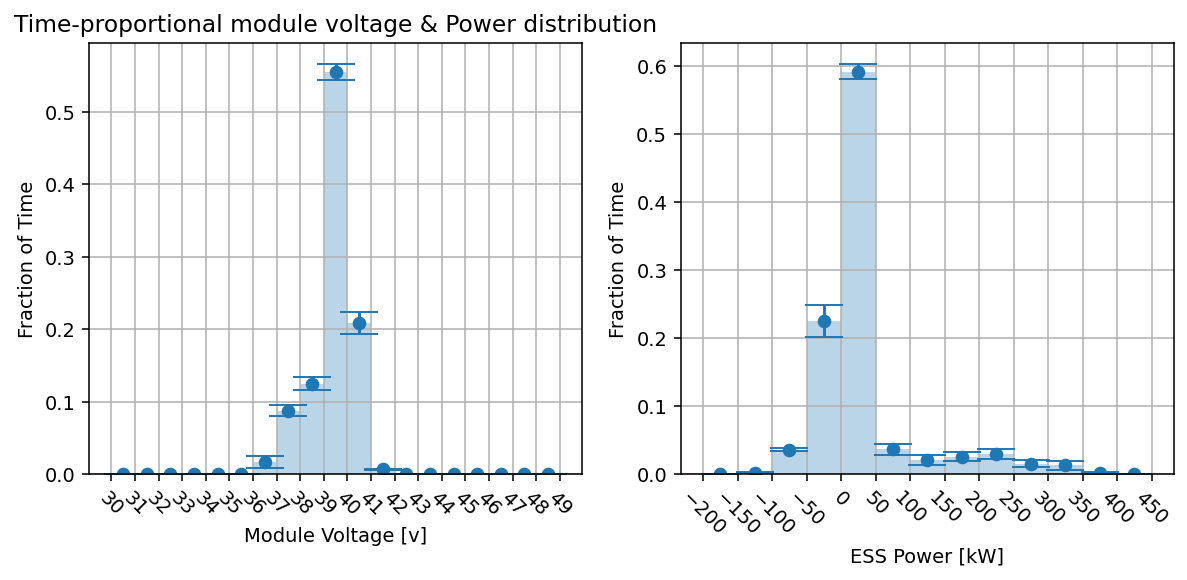


Route 40 Inbound: 
	Milage Min: 0.1679 kWh, Max: 0.4211 kWh, Average Mean: 0.2409+/-0.022 kWh, Average STD: 0.0399+/-0.0061 kWh
	Time Min: 2599.1112 s, Max: 8265.8562 s, Average Mean: 4686.3757+/-247.2742 s, Average STD: 984.1598+/-94.7228 s


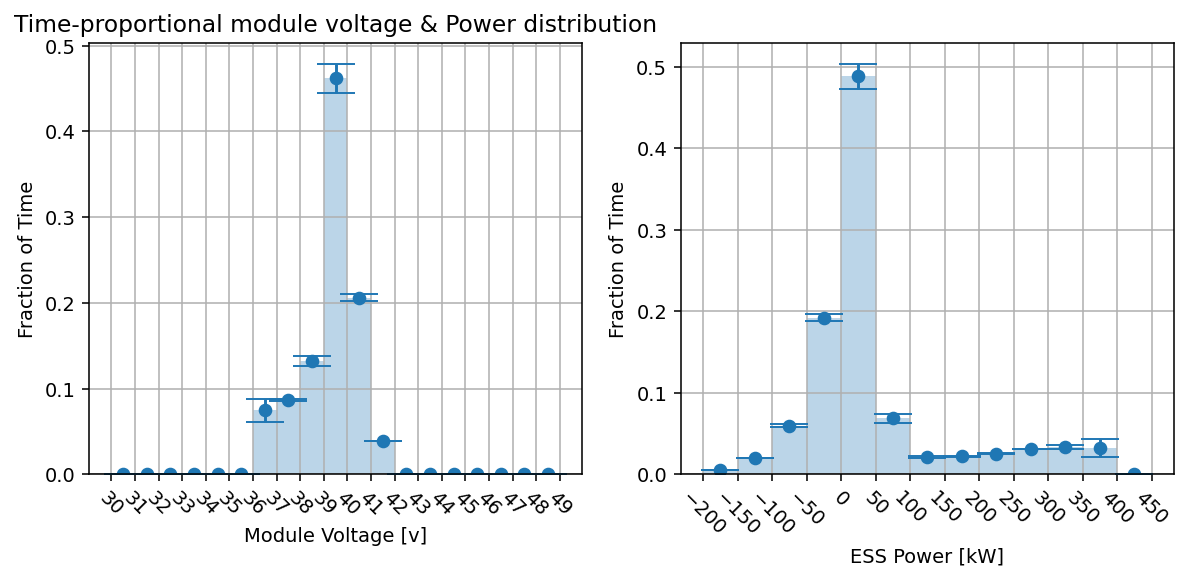

Route 40 Outbound: 
	Milage Min: 0.1646 kWh, Max: 0.4228 kWh, Average Mean: 0.2432+/-0.0301 kWh, Average STD: 0.0402+/-0.0077 kWh
	Time Min: 2707.8169 s, Max: 7337.7014 s, Average Mean: 4504.2015+/-117.2134 s, Average STD: 865.0705+/-16.8435 s


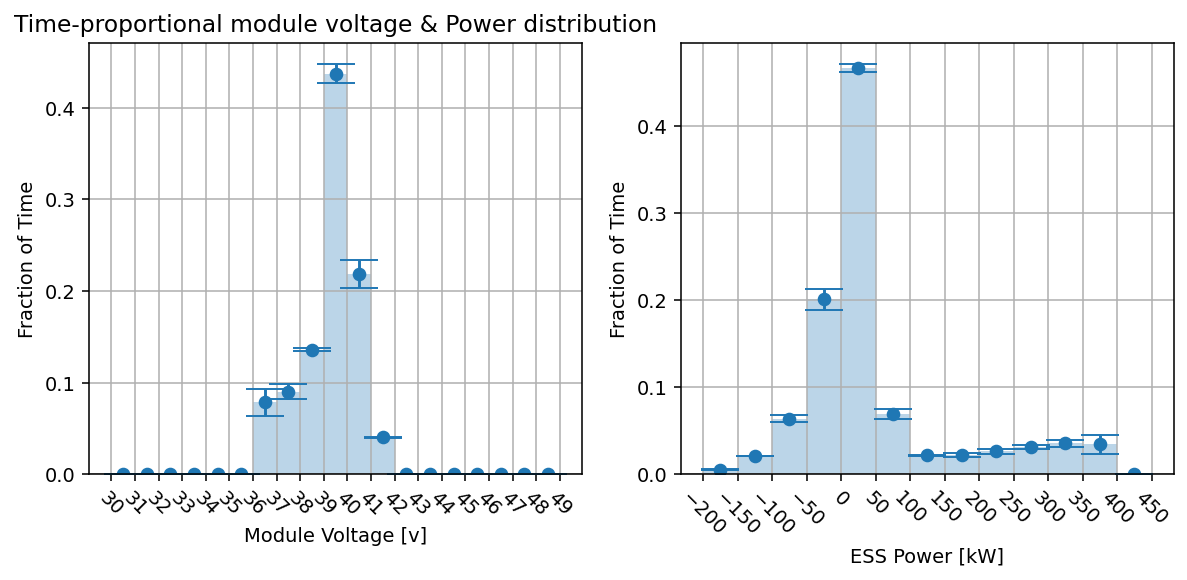


Route 45 Inbound: 
	Milage Min: 0.1614 kWh, Max: 0.4215 kWh, Average Mean: 0.2616+/-0.0225 kWh, Average STD: 0.0461+/-0.0054 kWh
	Time Min: 1148.713 s, Max: 4953.5192 s, Average Mean: 2653.082+/-407.3547 s, Average STD: 619.1885+/-60.728 s


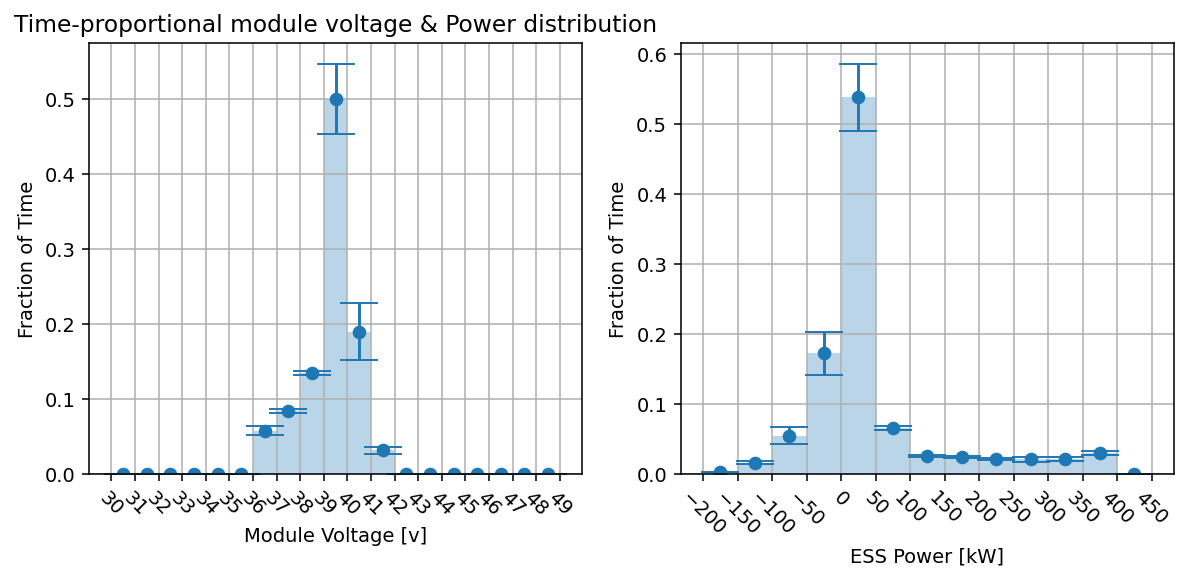

Route 45 Outbound: 
	Milage Min: 0.1575 kWh, Max: 0.4386 kWh, Average Mean: 0.2477+/-0.03 kWh, Average STD: 0.042+/-0.0105 kWh
	Time Min: 1178.8029 s, Max: 5152.9249 s, Average Mean: 2667.2705+/-744.3875 s, Average STD: 579.6471+/-165.068 s


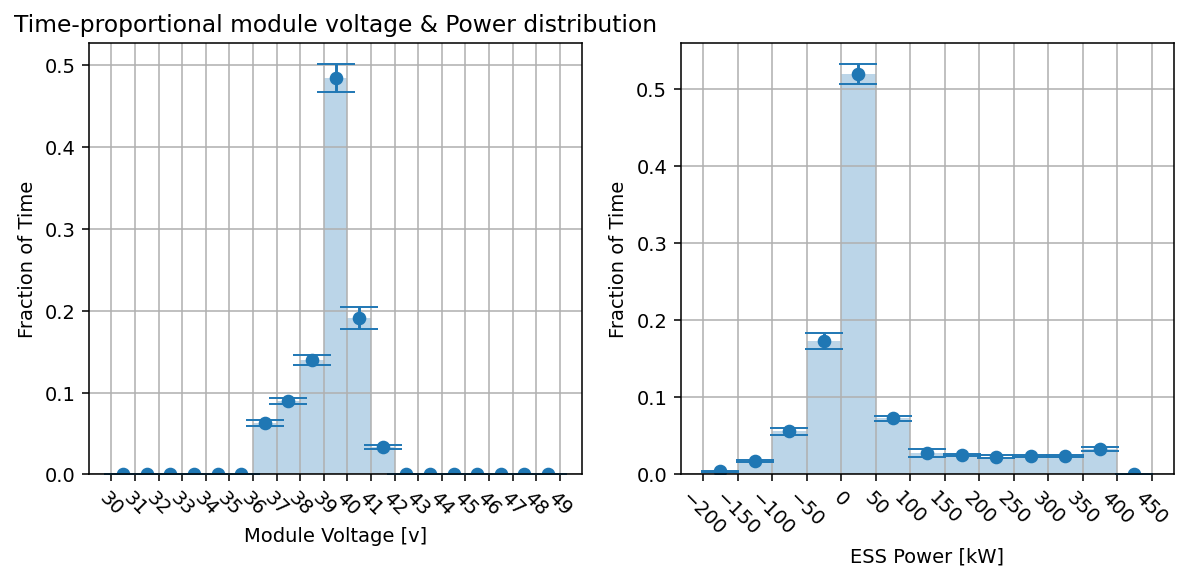


Route 48 Inbound: 
	Milage Min: 0.1463 kWh, Max: 0.4311 kWh, Average Mean: 0.2264+/-0.0318 kWh, Average STD: 0.0375+/-0.0078 kWh
	Time Min: 1526.2345 s, Max: 4341.7942 s, Average Mean: 2526.181+/-55.9951 s, Average STD: 512.2824+/-24.9435 s


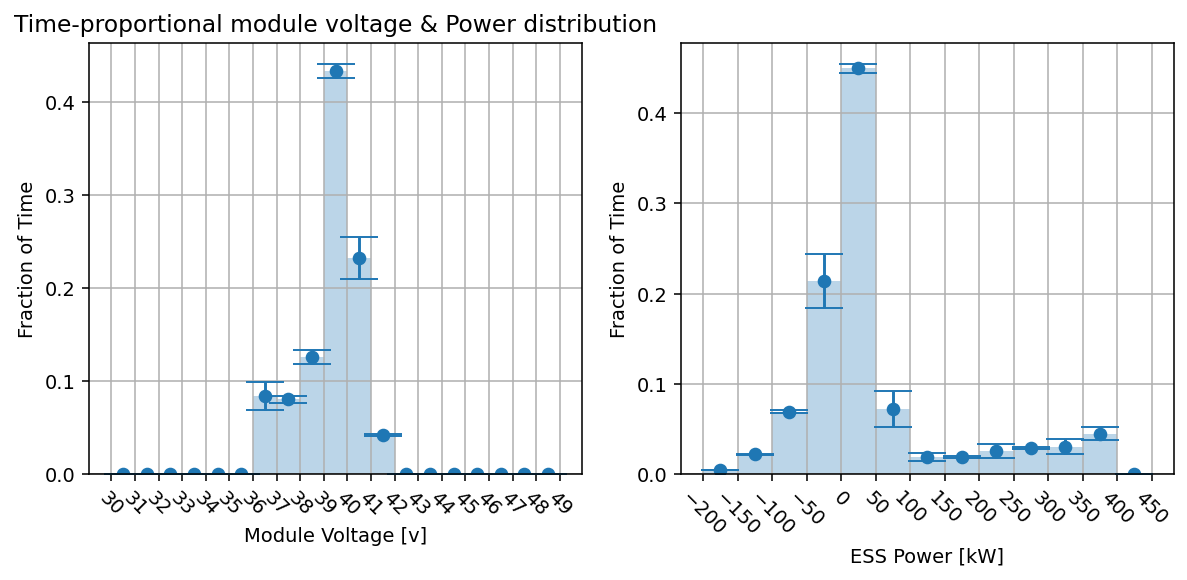

Route 48 Outbound: 
	Milage Min: 0.1497 kWh, Max: 0.4276 kWh, Average Mean: 0.2321+/-0.0362 kWh, Average STD: 0.0377+/-0.0091 kWh
	Time Min: 1375.9809 s, Max: 3662.5173 s, Average Mean: 2223.6747+/-55.9018 s, Average STD: 392.8465+/-32.522 s


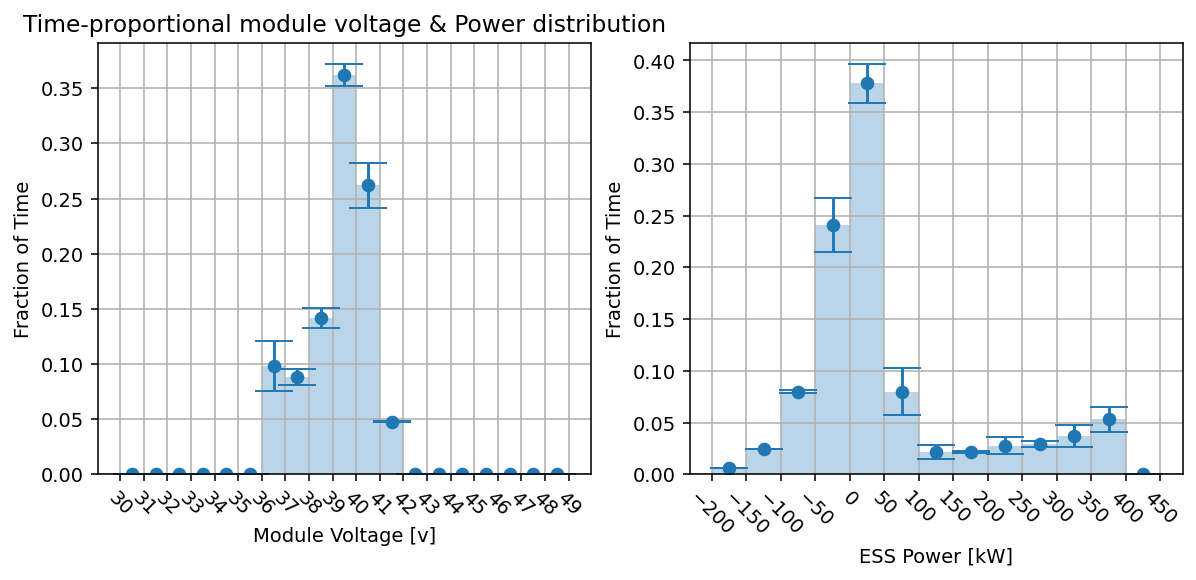


Route 49 Inbound: 
	Milage Min: 0.1932 kWh, Max: 0.455 kWh, Average Mean: 0.2909+/-0.0208 kWh, Average STD: 0.0414+/-0.0057 kWh
	Time Min: 1156.1472 s, Max: 3874.2464 s, Average Mean: 2099.2703+/-327.8974 s, Average STD: 409.4964+/-76.2959 s


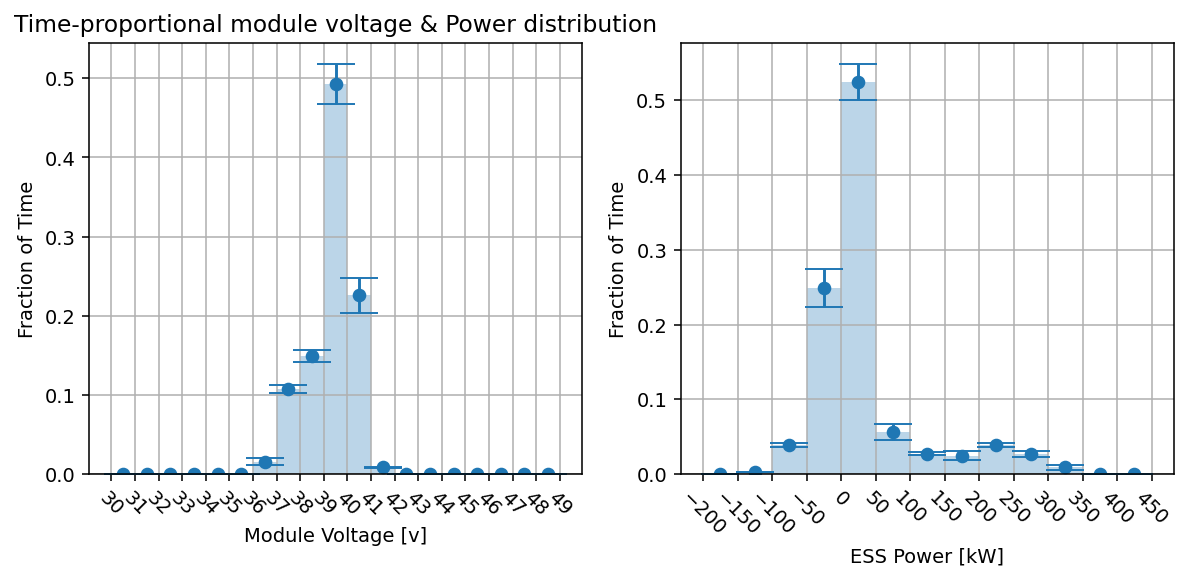

Route 49 Outbound: 
	Milage Min: 0.213 kWh, Max: 0.511 kWh, Average Mean: 0.3217+/-0.0164 kWh, Average STD: 0.0493+/-0.0032 kWh
	Time Min: 1149.8658 s, Max: 3737.8902 s, Average Mean: 2030.2782+/-238.2916 s, Average STD: 401.9862+/-39.12 s


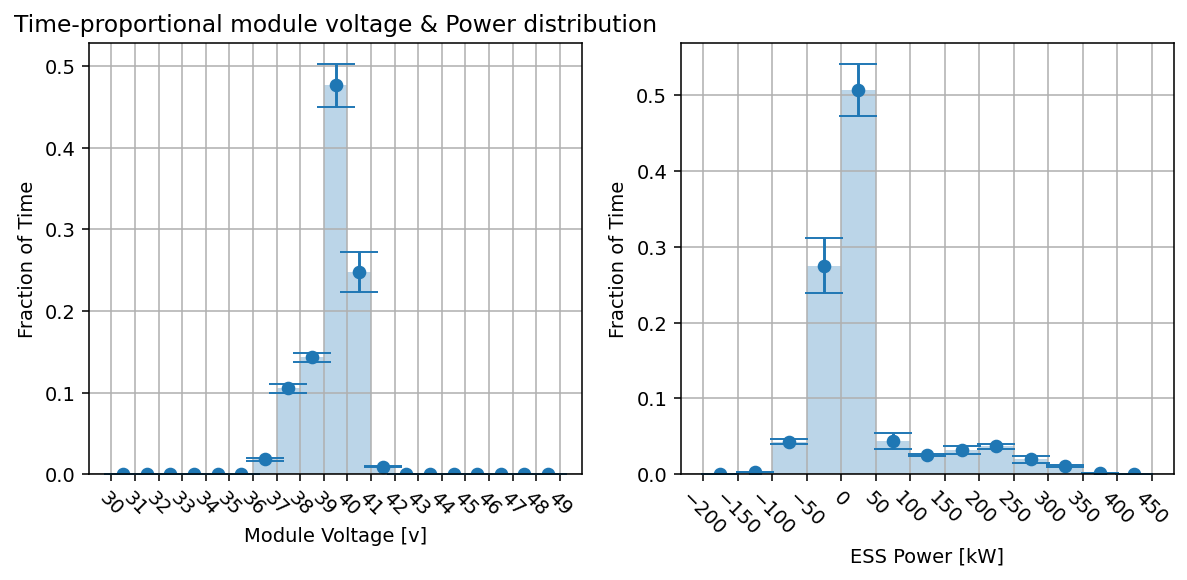


Route 4 Inbound: 
	Milage Min: 0.1658 kWh, Max: 0.4681 kWh, Average Mean: 0.2837+/-0.0217 kWh, Average STD: 0.0441+/-0.0061 kWh
	Time Min: 611.3802 s, Max: 5876.4821 s, Average Mean: 2245.9813+/-748.4591 s, Average STD: 513.6545+/-168.8285 s


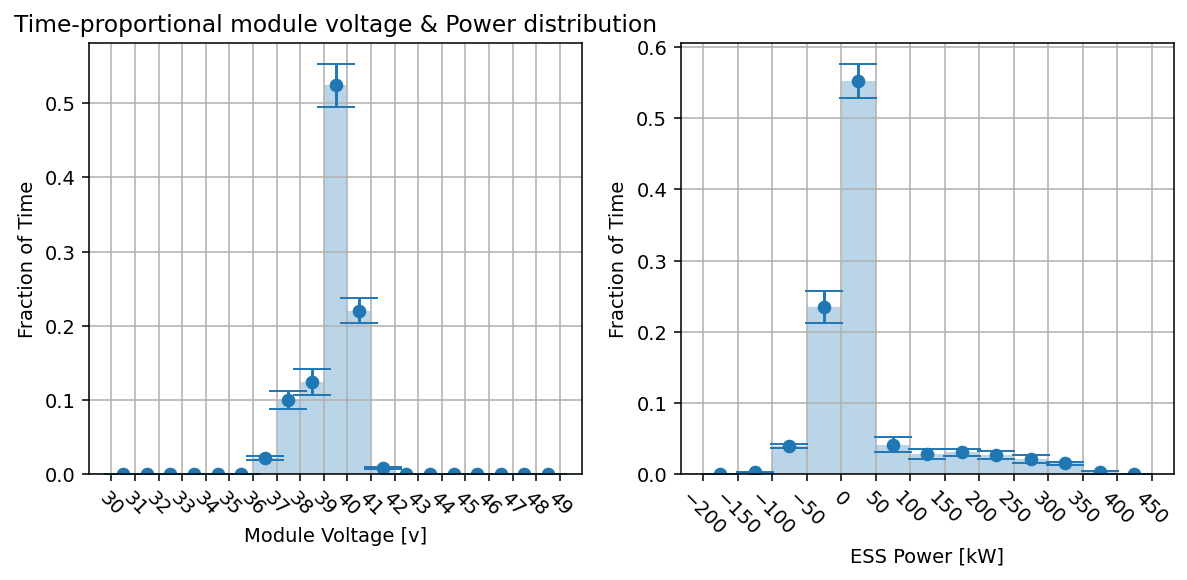

Route 4 Outbound: 
	Milage Min: 0.1692 kWh, Max: 0.4966 kWh, Average Mean: 0.2843+/-0.0254 kWh, Average STD: 0.0434+/-0.0063 kWh
	Time Min: 611.4352 s, Max: 5275.8889 s, Average Mean: 2215.6889+/-695.6271 s, Average STD: 497.6771+/-144.0442 s


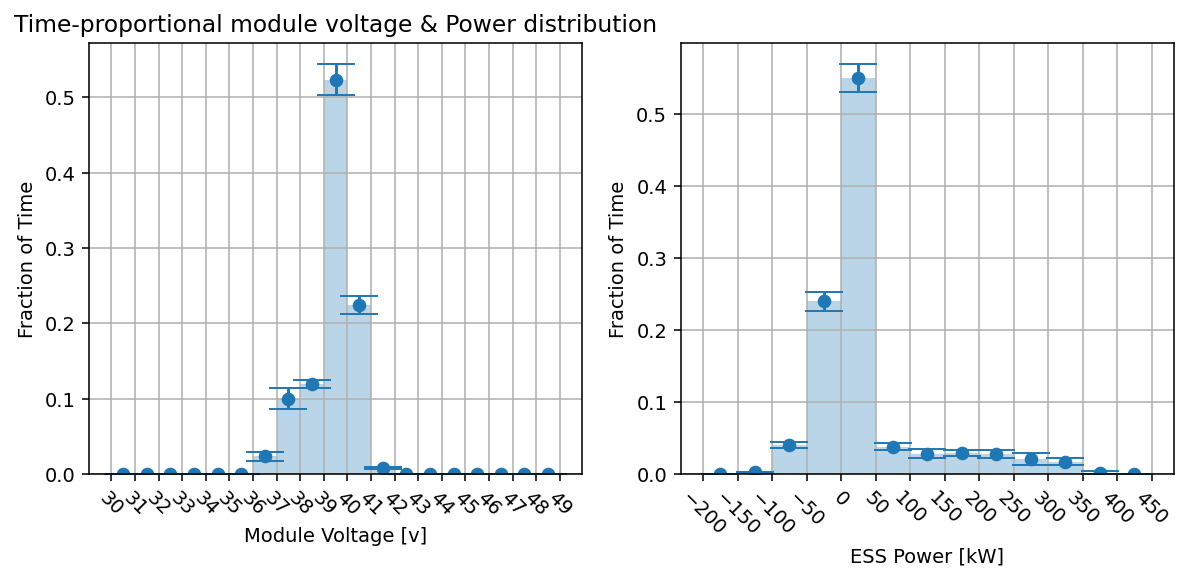


Route 50 Inbound: 
	Milage Min: 0.2432 kWh, Max: 0.6135 kWh, Average Mean: 0.3781+/-0.0225 kWh, Average STD: 0.059+/-0.0084 kWh
	Time Min: 2292.3336 s, Max: 7043.0211 s, Average Mean: 4201.7664+/-78.8796 s, Average STD: 923.0886+/-58.6156 s


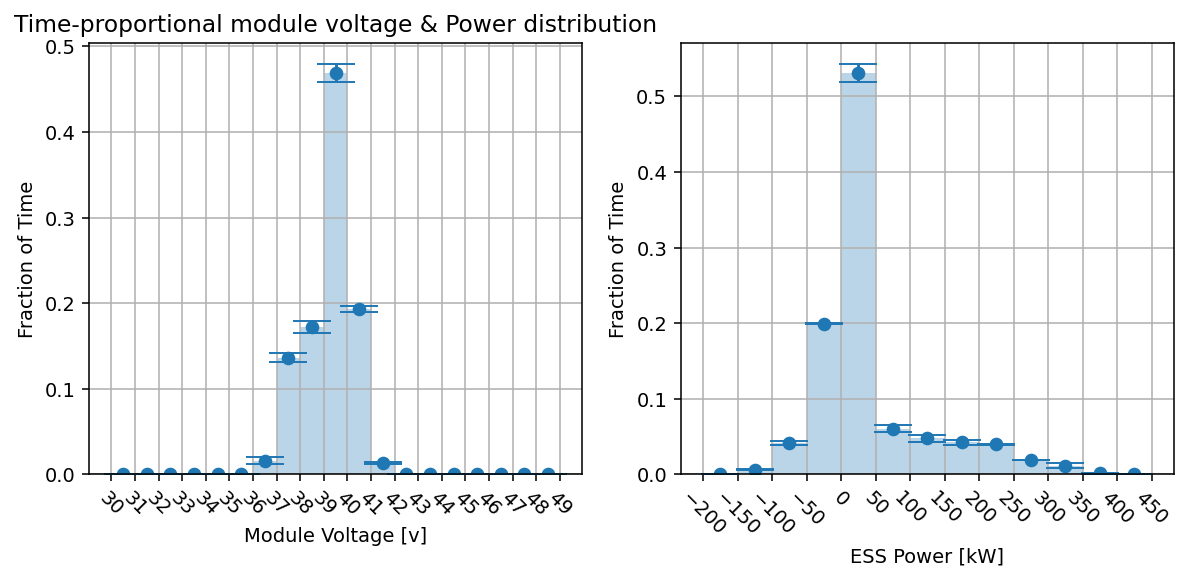

Route 50 Outbound: 
	Milage Min: 0.2378 kWh, Max: 0.6138 kWh, Average Mean: 0.3822+/-0.0396 kWh, Average STD: 0.0586+/-0.0091 kWh
	Time Min: 2309.3305 s, Max: 6474.2842 s, Average Mean: 3889.2181+/-231.44 s, Average STD: 793.0852+/-91.7694 s


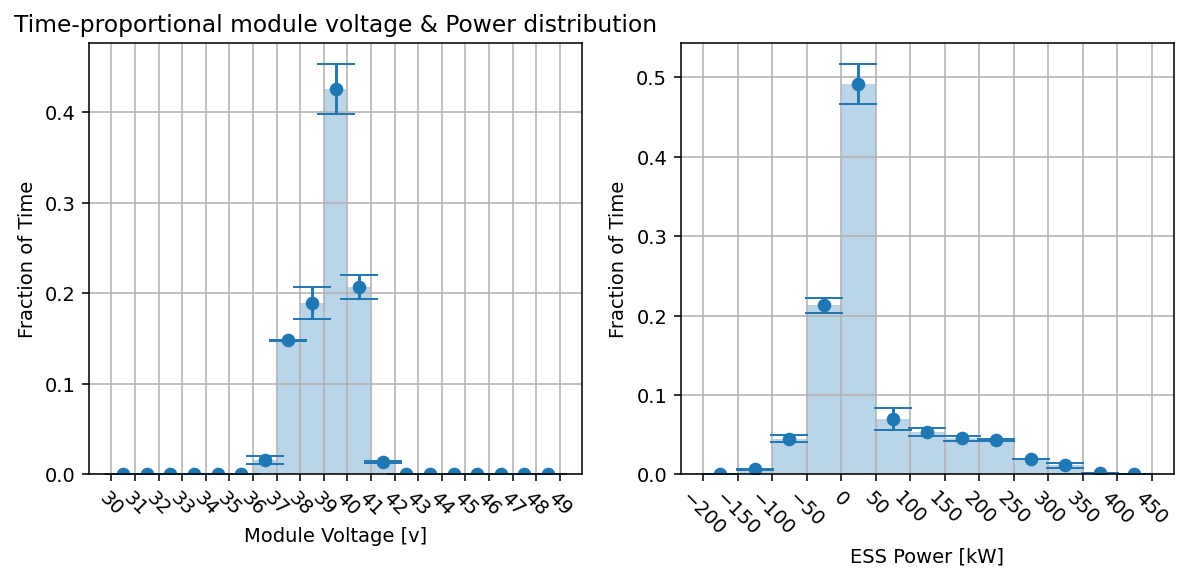


Route 5 Inbound: 
	Milage Min: 0.16 kWh, Max: 0.5062 kWh, Average Mean: 0.2732+/-0.0488 kWh, Average STD: 0.0498+/-0.0146 kWh
	Time Min: 1832.5327 s, Max: 6881.127 s, Average Mean: 3861.8051+/-404.6158 s, Average STD: 868.9306+/-58.3757 s


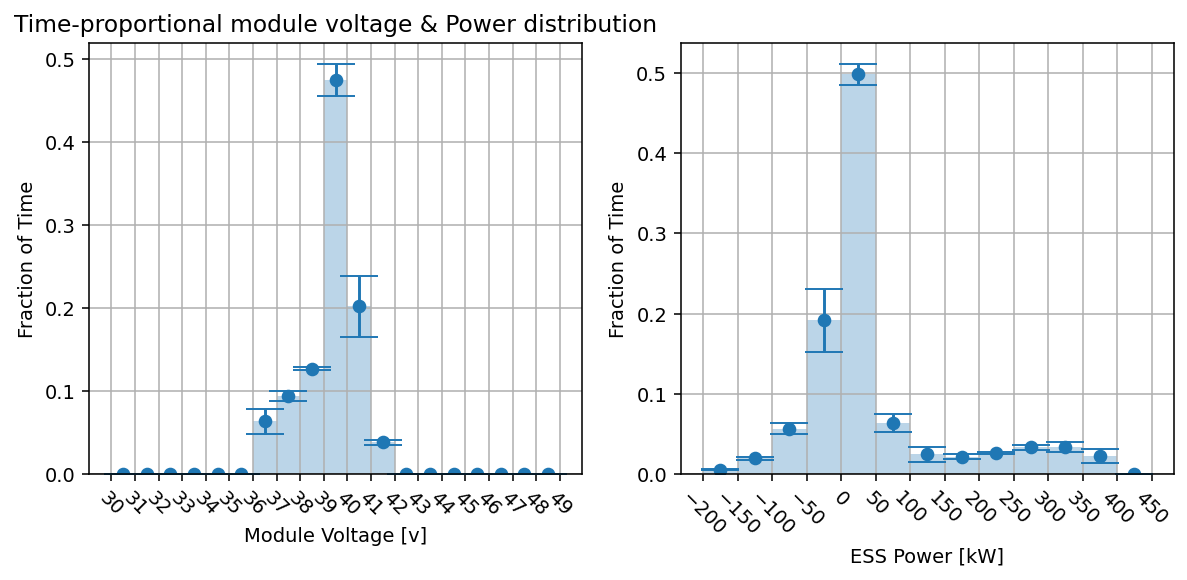

Route 5 Outbound: 
	Milage Min: 0.1564 kWh, Max: 0.4866 kWh, Average Mean: 0.2422+/-0.0513 kWh, Average STD: 0.0409+/-0.0164 kWh
	Time Min: 1871.9624 s, Max: 5714.7208 s, Average Mean: 3624.7684+/-332.8327 s, Average STD: 742.972+/-16.083 s


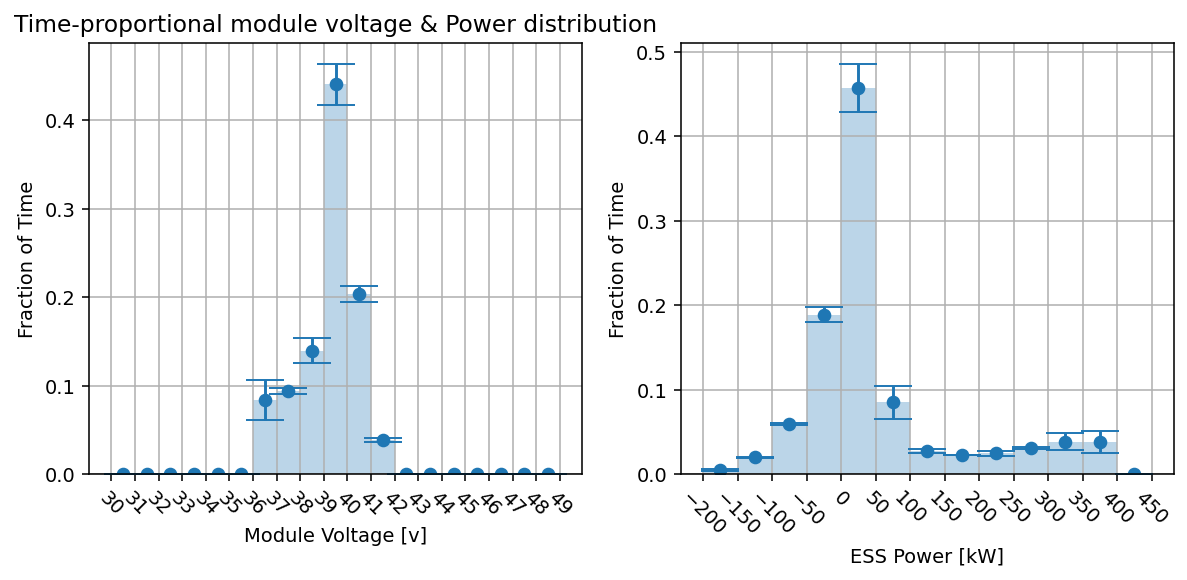


Route 65 Inbound: 
	Milage Min: 0.1501 kWh, Max: 0.4489 kWh, Average Mean: 0.2478+/-0.0462 kWh, Average STD: 0.0395+/-0.0132 kWh
	Time Min: 1256.5958 s, Max: 5686.3207 s, Average Mean: 2827.6606+/-526.432 s, Average STD: 704.4268+/-103.6964 s


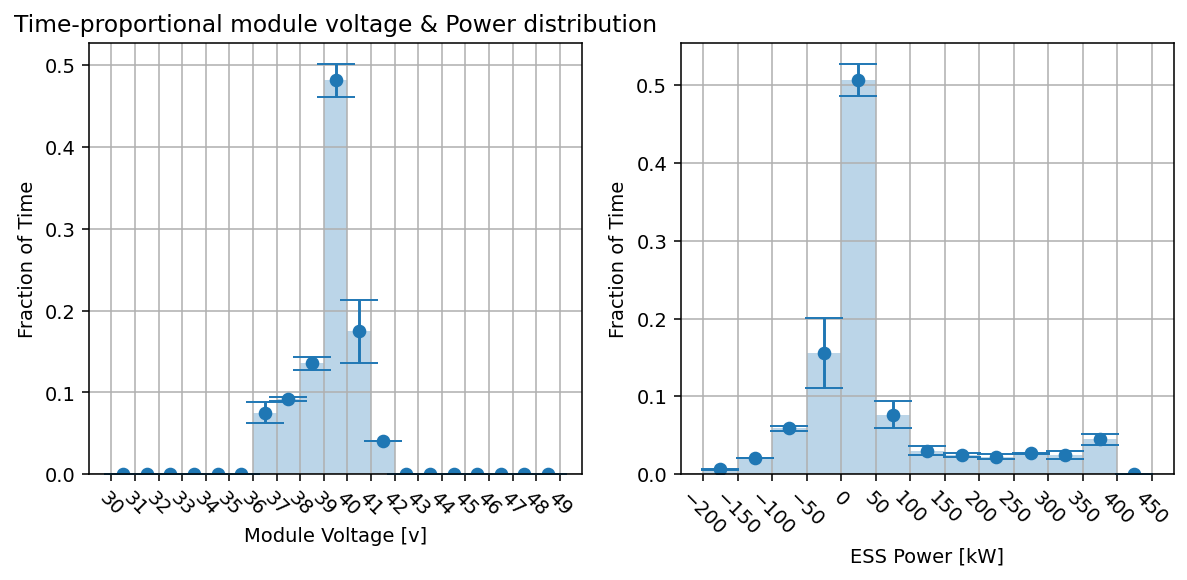

Route 65 Outbound: 
	Milage Min: 0.1725 kWh, Max: 0.4905 kWh, Average Mean: 0.2731+/-0.0513 kWh, Average STD: 0.0464+/-0.0157 kWh
	Time Min: 1239.1693 s, Max: 5366.2087 s, Average Mean: 2753.0466+/-632.5991 s, Average STD: 572.2112+/-104.3382 s


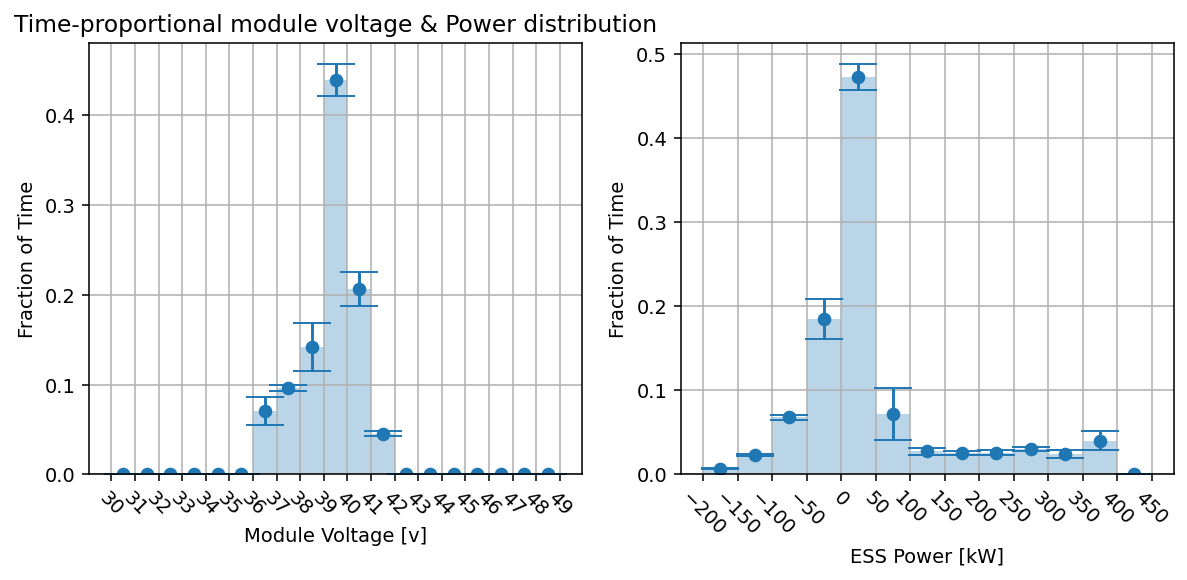


Route 75 Inbound: 
	Milage Min: 0.1684 kWh, Max: 0.3794 kWh, Average Mean: 0.2482+/-0.0119 kWh, Average STD: 0.0397+/-0.0026 kWh
	Time Min: 1345.3047 s, Max: 6427.3478 s, Average Mean: 3039.5684+/-816.0897 s, Average STD: 702.5963+/-221.8849 s


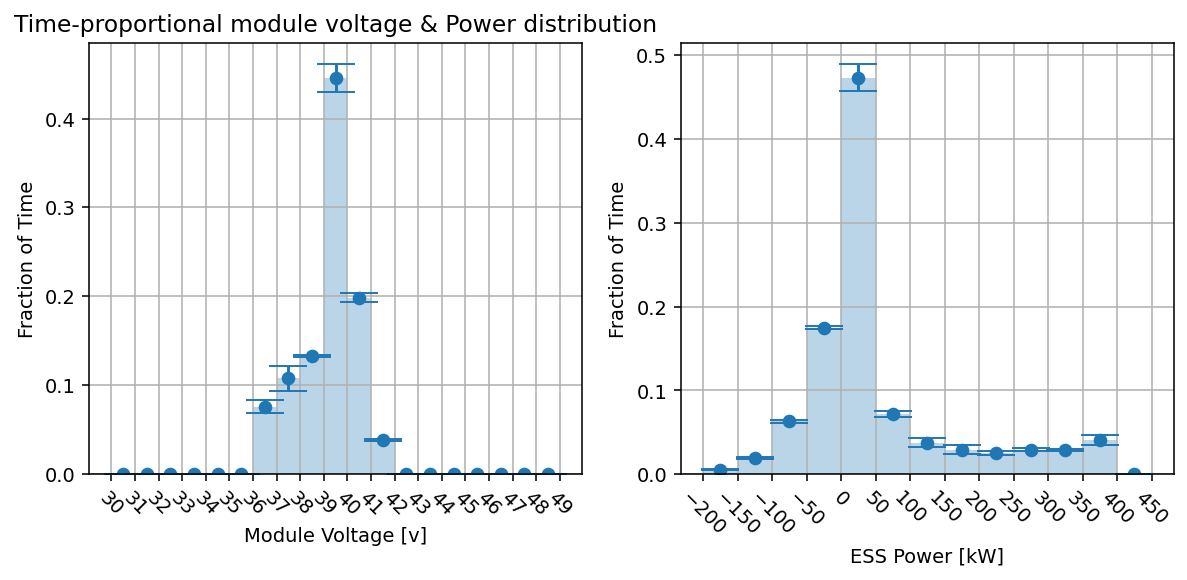

Route 75 Outbound: 
	Milage Min: 0.18 kWh, Max: 0.4299 kWh, Average Mean: 0.2655+/-0.0208 kWh, Average STD: 0.0433+/-0.0076 kWh
	Time Min: 1508.2818 s, Max: 6060.2082 s, Average Mean: 3107.5285+/-716.1321 s, Average STD: 672.0806+/-140.354 s


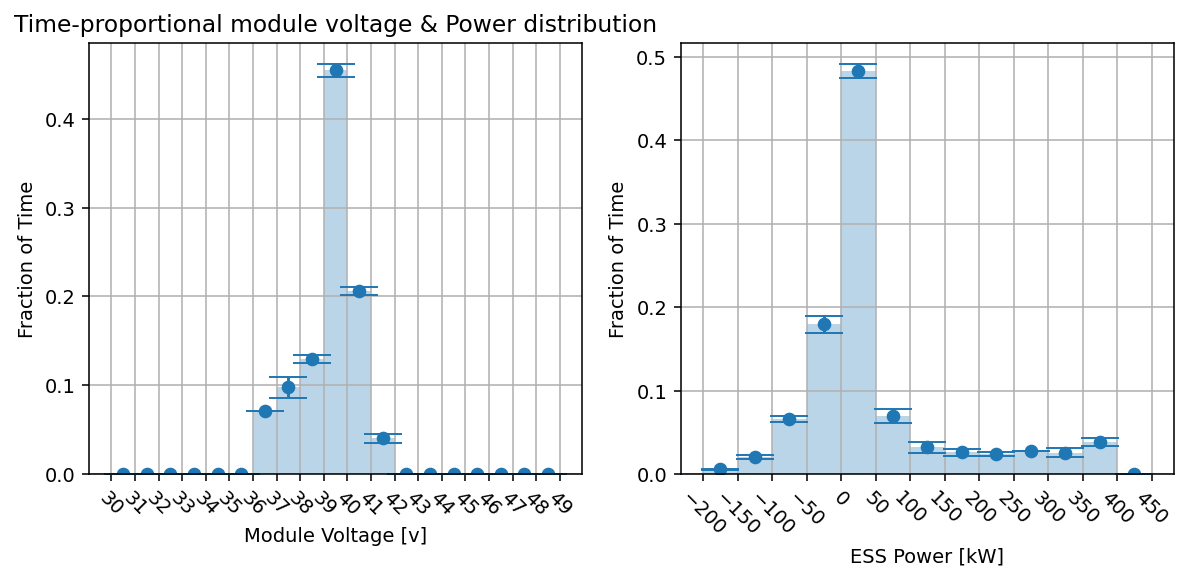


Route 62 Inbound: 
	Milage Min: 0.1698 kWh, Max: 0.3705 kWh, Average Mean: 0.2452+/-0.0109 kWh, Average STD: 0.0362+/-0.0025 kWh
	Time Min: 2323.6684 s, Max: 7784.871 s, Average Mean: 4283.3088+/-126.0477 s, Average STD: 933.5141+/-20.2968 s


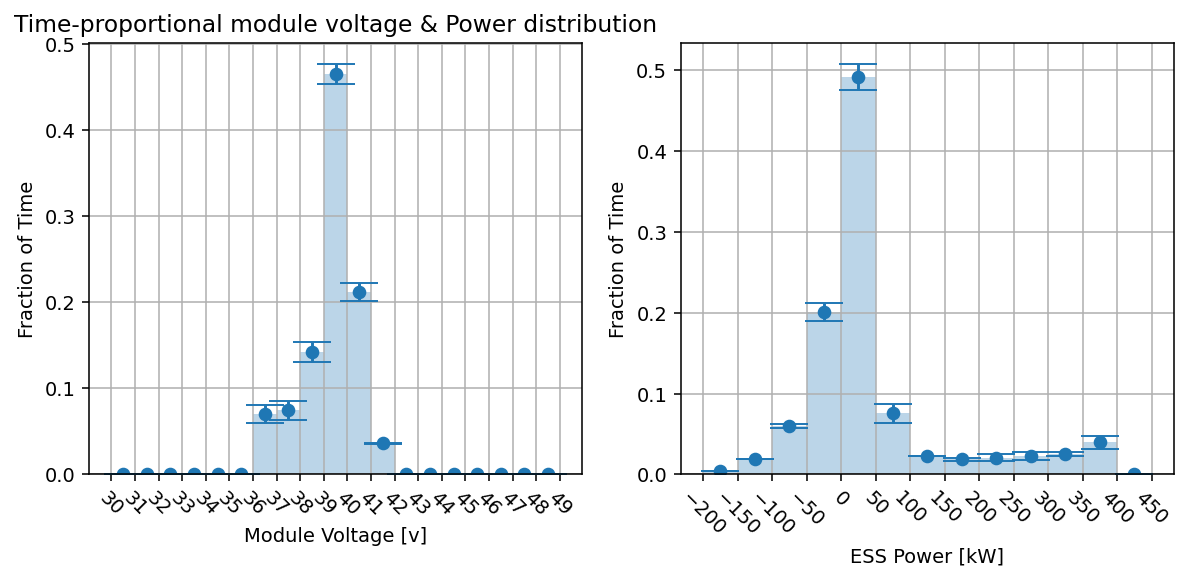

Route 62 Outbound: 
	Milage Min: 0.1656 kWh, Max: 0.3767 kWh, Average Mean: 0.2445+/-0.0166 kWh, Average STD: 0.0354+/-0.0027 kWh
	Time Min: 2131.6466 s, Max: 7546.9265 s, Average Mean: 4169.5172+/-283.5378 s, Average STD: 870.4874+/-138.309 s


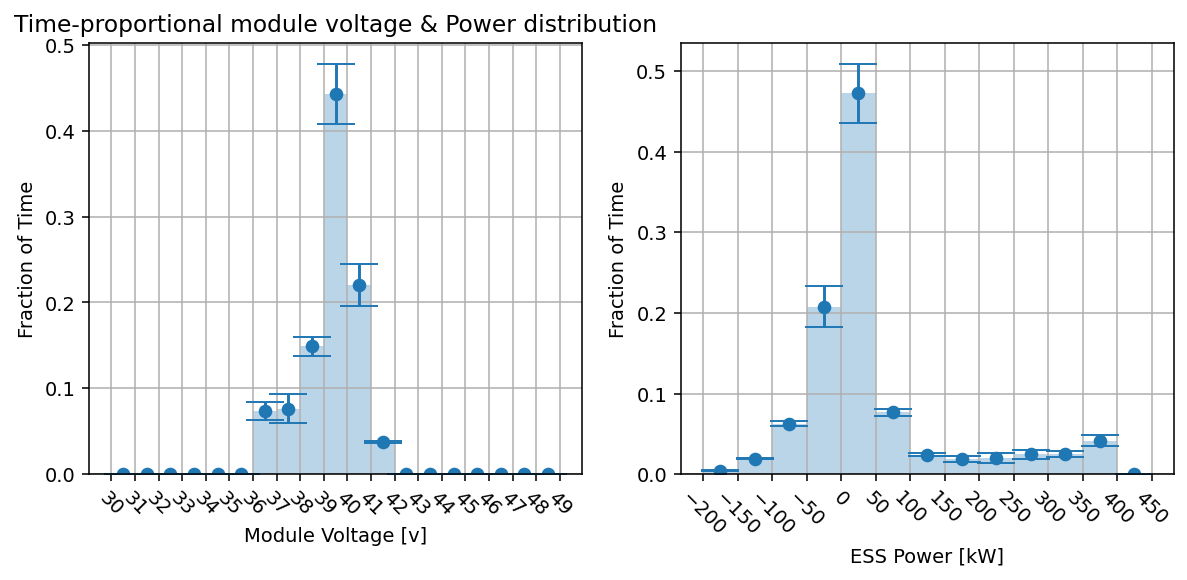


Route 67 Inbound: 
	Milage Min: 0.1441 kWh, Max: 0.4105 kWh, Average Mean: 0.2361+/-0.0396 kWh, Average STD: 0.0381+/-0.0075 kWh
	Time Min: 871.7375 s, Max: 5332.0757 s, Average Mean: 2213.6108+/-846.5384 s, Average STD: 537.0576+/-217.8202 s


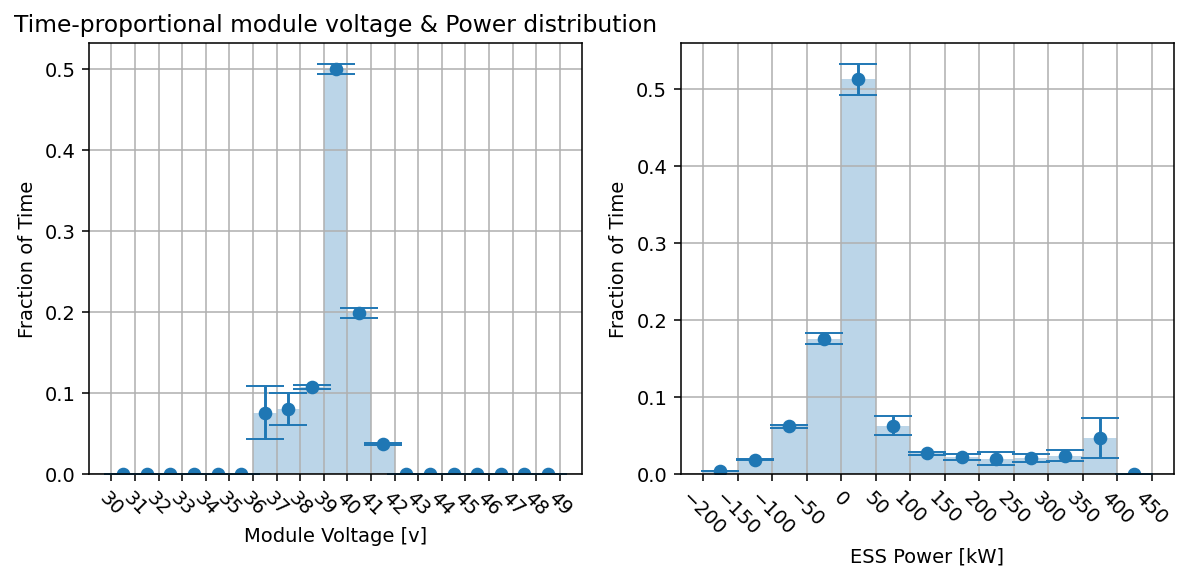

Route 67 Outbound: 
	Milage Min: 0.1566 kWh, Max: 0.3876 kWh, Average Mean: 0.2334+/-0.0297 kWh, Average STD: 0.0366+/-0.0093 kWh
	Time Min: 895.4708 s, Max: 4936.9898 s, Average Mean: 2121.3067+/-815.6183 s, Average STD: 451.429+/-207.0597 s


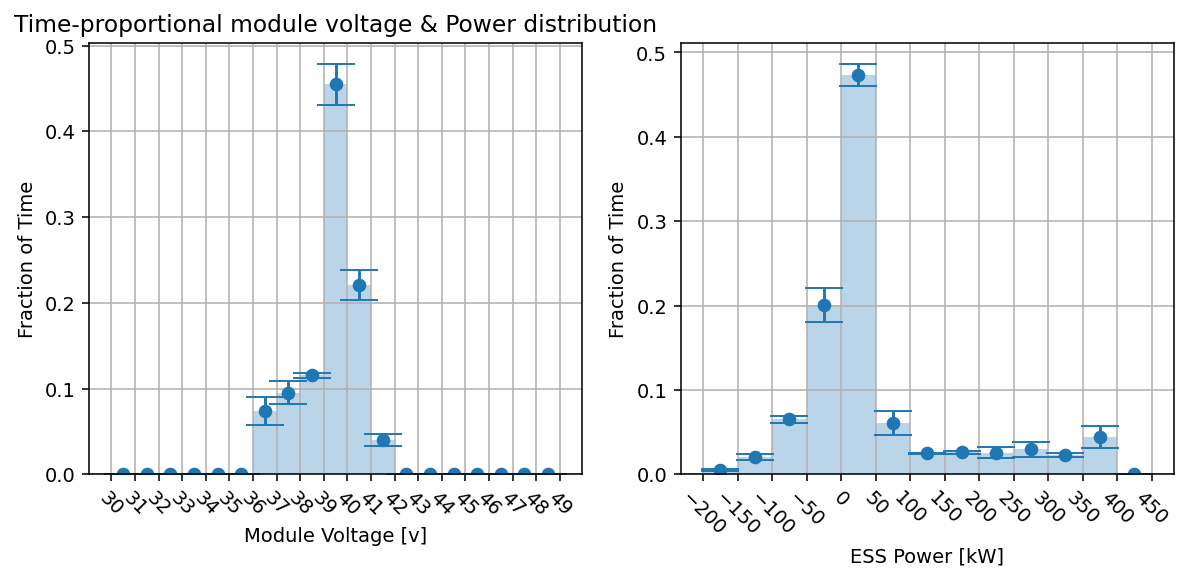


Route 70 Inbound: 
	Milage Min: 0.1498 kWh, Max: 0.3902 kWh, Average Mean: 0.2236+/-0.0273 kWh, Average STD: 0.0338+/-0.0083 kWh
	Time Min: 1288.4776 s, Max: 3705.9619 s, Average Mean: 2188.8114+/-71.1979 s, Average STD: 442.9505+/-44.6225 s


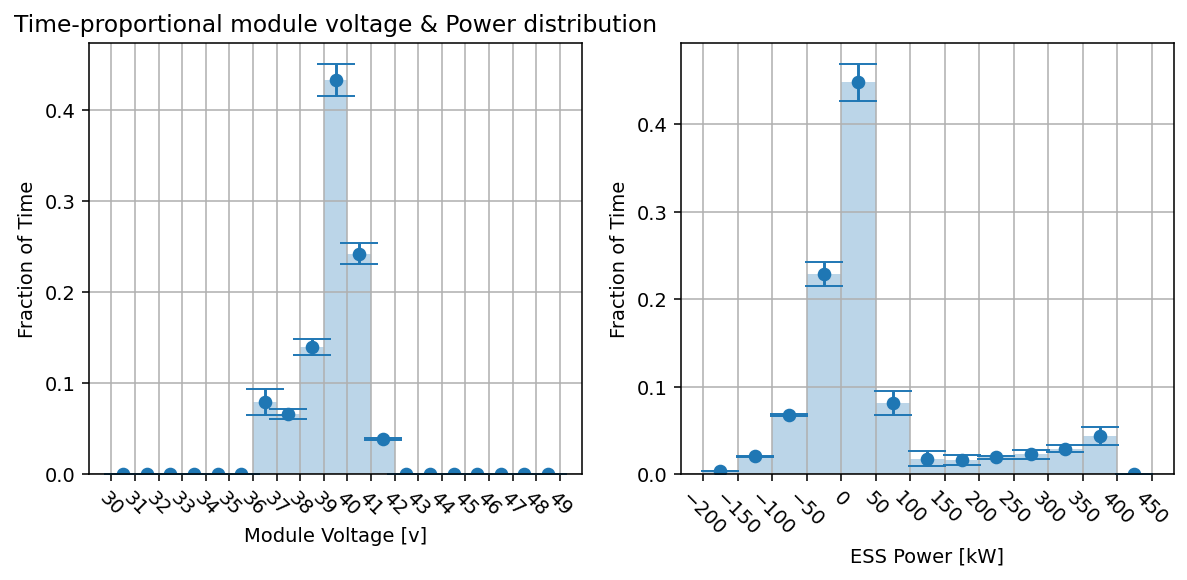

Route 70 Outbound: 
	Milage Min: 0.1475 kWh, Max: 0.3936 kWh, Average Mean: 0.2275+/-0.0305 kWh, Average STD: 0.0346+/-0.0073 kWh
	Time Min: 1363.7697 s, Max: 3371.9393 s, Average Mean: 2134.827+/-103.2023 s, Average STD: 403.8684+/-22.3363 s


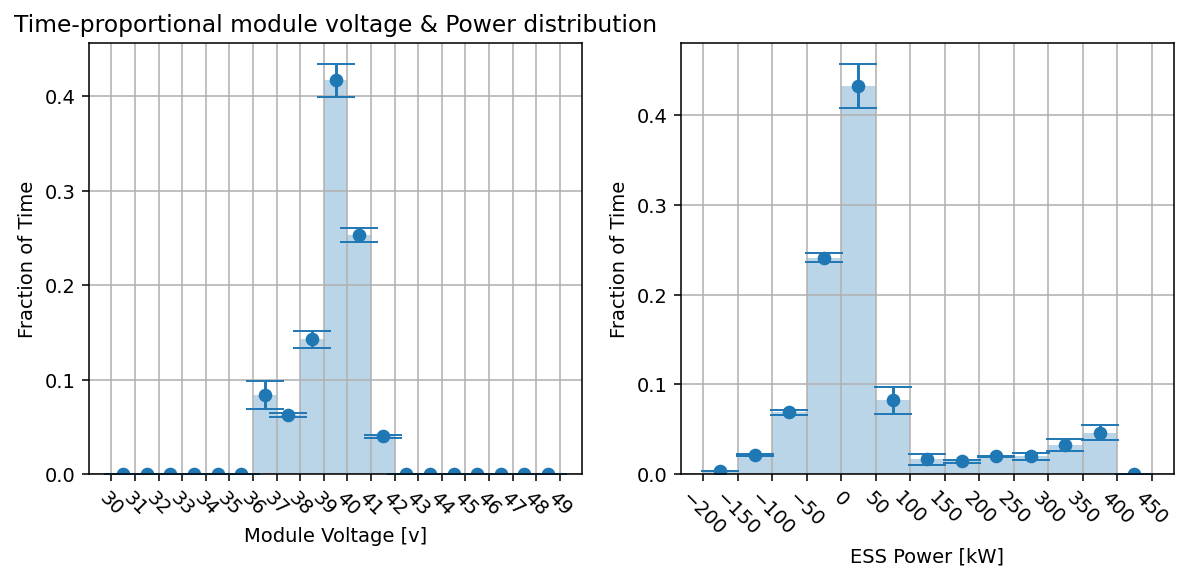


Route 8 Inbound: 
	Milage Min: 0.1638 kWh, Max: 0.3393 kWh, Average Mean: 0.2327+/-0.0091 kWh, Average STD: 0.0305+/-0.0038 kWh
	Time Min: 1650.3736 s, Max: 4668.3048 s, Average Mean: 2887.7029+/-196.2031 s, Average STD: 590.1613+/-70.0162 s


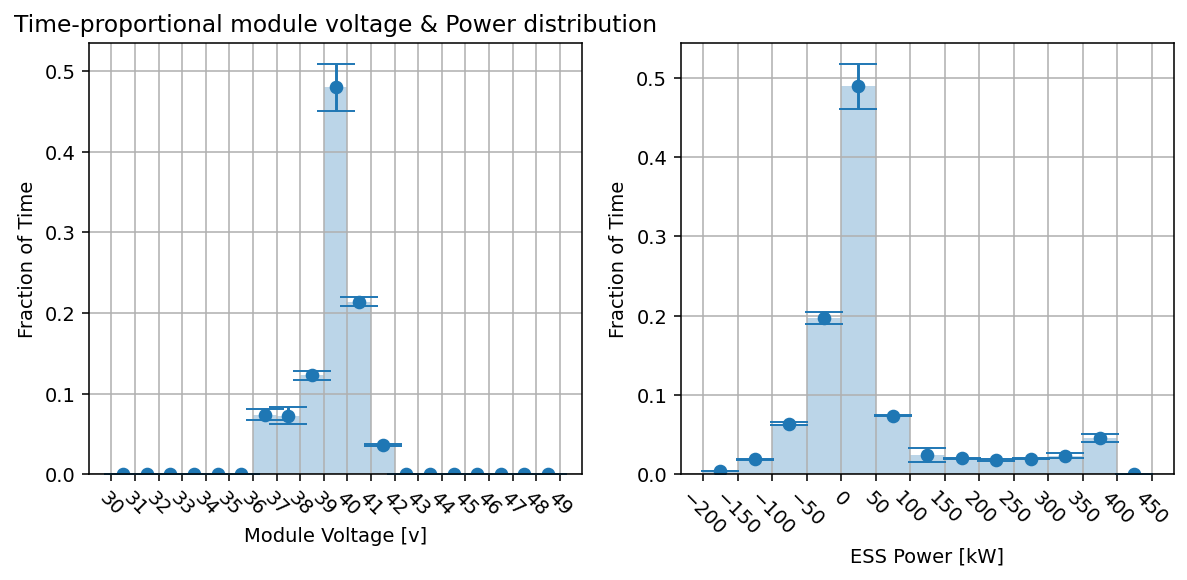

Route 8 Outbound: 
	Milage Min: 0.1615 kWh, Max: 0.3493 kWh, Average Mean: 0.2357+/-0.0152 kWh, Average STD: 0.0315+/-0.0046 kWh
	Time Min: 1572.9779 s, Max: 4467.9199 s, Average Mean: 2774.6044+/-48.5902 s, Average STD: 584.1904+/-22.1956 s


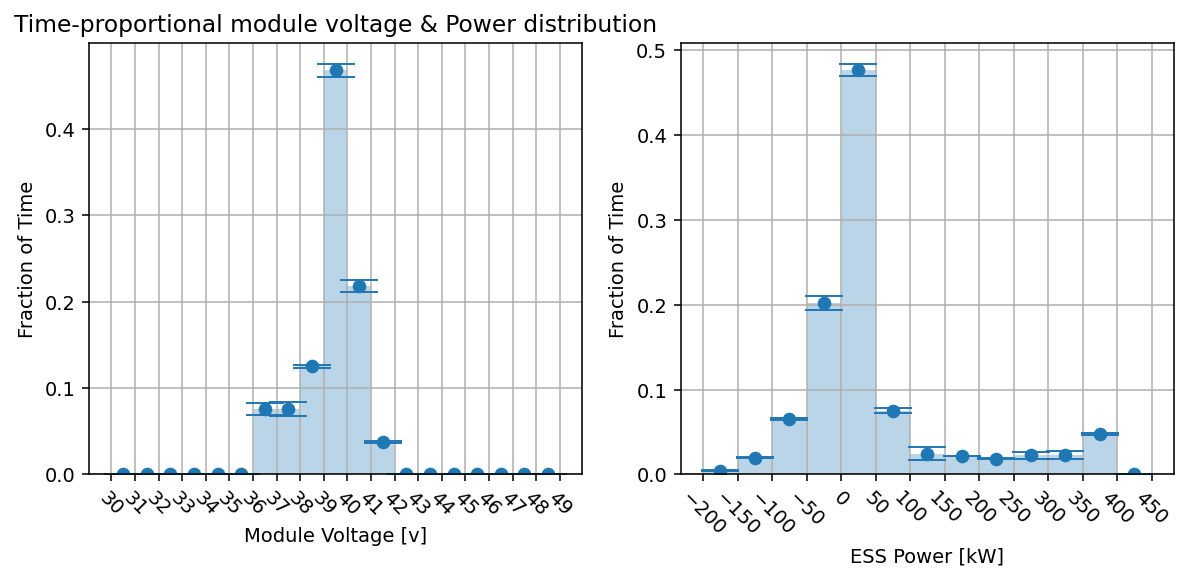

In [451]:
interpret_trip_statistics(trip_stats)

In [453]:
trip_stats.to_pickle('trip_statistics.pk')

In [ ]:
XDE60_ESS = op.ESS(motor_eff = .93, # @Gallet. No clear source on where these drivetrain, inverter, and motor efficiencies came from. Can't find TB200 specs yet.
                   inverter_eff = .88, # @Gallet
                   aux_eff = .89, # Assumption.
                   regen_eff = .54, # Assumption.
                   simple_load = 8000,
                   max_regen = -200000, #w, finally, some good sourcable values.@XDE35_Manual
                   module_struct = (12,8),
                   bus_struct = (16,40))


XDE60 = op.Bus(bus_mass = 20638, #kg, @NF_Xcelsior
               frontal_width = 2.6, #m,@NF_Xcelsior
               frontal_height = 3.38, #m, @NF_Xcelsior
               drag_coeff = .7, # Unitless. Many suspect papers cite .6, but best bet was one citing ORNL bus database saying .79, @Gao_Et_Al
               friction_coeff = .01, # unitless, otherwise known as rolling resistance. @Rolling_Resistance
               braking_accel = 1.5, #1.5m/s^2, handbrake required to stop from 20 mph, over no set distance. emergency brake must be capable of up to 6.5m/s^2 (20 mph over 20 ft).@APTA_Braking_Standards
               br_factor = .5, # driver braking aggression. Variable based on driver.
               i_factor = 1.1, # unitless, accounts for wheels, driveshaft, etc, cited from @Gallet
                               # however, there is no substantive explanation as to how it was calculated/obtained.
               max_dist = 304.8, # m, expected stopping distance for a bust from 60 mph calculated from google map offramp length measurements of I-5.
               max_acc = .4, # m/s^2, chosen due to it being a decent extension of existing drive cycle. subject to change.
               max_dt = .5, #s, timestep for that extension. 
               max_P = 300000 # W, @Siemens_Traction_Motor 
              )
    
XDE60_ESS.calc_voltage_simple(XDE60_ESS.calc_instance_power(68440000))

XDE40_ESS =  op.ESS(motor_eff = .93, # @Gallet. No clear source on where these drivetrain, inverter, and motor efficiencies came from. Can't find TB200 specs yet.
                   inverter_eff = .88, # @Gallet
                   aux_eff = .89, # Assumption.
                   regen_eff = .54, # Assumption.
                   simple_load = 8000,
                   max_regen = -200000, #w, finally, some good sourcable values.@XDE35_Manual
                   module_struct = (12,8),
                   bus_struct = (16,32)
                   
                   # W @Siemens_Traction_Motor
                  )

XDE35_ESS =  op.ESS(motor_eff = .93, # @Gallet. No clear source on where these drivetrain, inverter, and motor efficiencies came from. Can't find TB200 specs yet.
                   inverter_eff = .88, # @Gallet
                   aux_eff = .89, # Assumption.
                   regen_eff = .54, # Assumption.
                   simple_load = 8000,
                   max_regen = -200000, #w, finally, some good sourcable values.@XDE35_Manual
                   module_struct = (12,8),
                   bus_struct = (16,32)
                   
                   # W @Siemens_Traction_Motor
                  )



In [27]:
import ast
import random
def optimizefunc(func, ranges):
    '''
    optimizefunc takes a function with n parameters, and a set of n ranges for each parameter,
    and attempts to minimize the return value of the function. 
    '''
    # Set seed for optimization randomization
    random.seed(42)
    
    # Max iterations is 30
    max_iterations=1000
    iterations = 0
    
    rep_iterations = 0
    # Get number of dimensions for hyper-triangle
    ndim = 1+ len(ranges)
    
    # Dictionary for the points
    point_dict = {}
    lowest_max = (9999, 0)
    # render the first point set, this could be done with multiprocessing
    for i in range(ndim):
        args = []
        for j in range(len(ranges)):
            #print(ranges[j])
            arg = random.uniform(*ranges[j])
            args.append(arg)
        result = func(*tuple(args))
        point_dict[str(args)]=result

    # Loop the number of times specified
    while iterations < max_iterations:
        
        print("Evaluating literals...", end='\r')
        
        # get the furthest point's parameters
        furthest_pt = ast.literal_eval(max(point_dict, key=point_dict.get))
        furthest_val = point_dict[max(point_dict, key=point_dict.get)]
        
        # Check if the lowest max value is higher than the current
        if furthest_val < lowest_max[0]:
            lowest_max = (furthest_val, furthest_pt)

        # remove it from the dict
        del point_dict[max(point_dict, key=point_dict.get)]
        
        print("Loading hyperplane params...", end='\r')
        # get the vectors for the hyperplane
        hyperplane_vectors = list(point_dict.keys())
        
        # Convert them to actual vectors
        for i in range(len(hyperplane_vectors)):
            hyperplane_vectors[i] = ast.literal_eval(hyperplane_vectors[i])
        
        print("Calculating hyperplane...", end='\r')
        # get the hyperplane equation
        hyperplane_eqn = np.linalg.solve(hyperplane_vectors, [-1]*len(hyperplane_vectors))
        
        print("Evaluating hyperplane normal...", end='\r')
        # get the hyperplane normal
        hyperplane_normal_len = np.sqrt(sum(np.square(hyperplane_eqn)))
        
        # get the normalized hyperplane vector
        normalized_vector = hyperplane_eqn/hyperplane_normal_len
        
        print("Calculating Mirror Point...", end='\r')
        # Get the sign distance for the furthest point
        signdist = sum(normalized_vector*furthest_pt)
        
        # Get the mirrored version of that point
        mirrorpt = furthest_pt -2*normalized_vector*signdist
        
        mirrorpt = ensure_in_range(mirrorpt, ranges)
        
        print("Calculating Centroid...", end='\r')
        # Calculate the centroid of the hyperplane and mirror
        centroid = (sum([np.asarray(ls) for ls in hyperplane_vectors]) + mirrorpt)/(len(hyperplane_vectors)+1)
        centroid = ensure_in_range(centroid, ranges)
        
        print("Running Mirror Point...", end='\r')
        # run the function with the mirror and the centroid
        mir = func(*mirrorpt)
        print("Running Centroid Point...", end='\r')
        cent = func(*centroid)
        
        # if the mirror result is lower than the centroid, keep it
        if mir < cent:
            point_dict[str(mirrorpt.tolist())] = mir
            
        # otherwise, keep the centroid result
        else:
            point_dict[str(centroid.tolist())] = cent
        
        if point_dict[max(point_dict, key=point_dict.get)] == furthest_val:
            rep_iterations += 1
        
        if rep_iterations > 2: 
            closest_key = min(point_dict, key=point_dict.get)
            closest_val = point_dict[closest_key]
            point_dict = {}
            point_dict[closest_key] = closest_val
            for i in range(ndim-1):
                args = []
                for j in range(len(ranges)):
                    #print(ranges[j])
                    arg = random.uniform(*ranges[j])
                    args.append(arg)
                result = func(*tuple(args))
                point_dict[str(args)]=result
            rep_iterations = 0
        # update iterations. 
        #print(iterations, point_dict[min(point_dict, key=point_dict.get)], point_dict[max(point_dict, key=point_dict.get)])
        iterations+=1
    
    # return the lowest value parameter set found. 
    print(lowest_max)
    return min(point_dict, key=point_dict.get), point_dict[min(point_dict, key=point_dict.get)]

def ensure_in_range(point, point_bounds):
    '''
    verifies that a point in n dimensions lies within the n bounds [(min, max) * n],
    and if it isnt, set the point to be within the bounds.
    '''
    for i in range(len(point)):
        param_bounds = point_bounds[i]
        if point[i] < min(param_bounds):
            point[i] = min(param_bounds)
        elif point[i]> max(param_bounds):
            point[i] = max(param_bounds)
        else:
            point[i]=point[i]
    return point

In [41]:
from reRoute_Dynamics import Physics_Engine as pe

def buspower_brake(ve, dx, g, b, wb, ws):
    return (XDE60_ESS.calc_voltage_simple(XDE60_ESS.calc_instance_power(
             pe.brake(ve,
                     XDE60.mass,
                     dx,
                     pe.calculate_grade_force(g, XDE60.mass, XDE60.Cf),
                     pe.calculate_wind_force(b, ve, wb, ws, drag_coeff = XDE60.Cd, frontal_area = XDE60.area),
                     XDE60.a_br,
                     XDE60.f_br,
                     XDE60.f_i,
                     XDE60.dmax)['P'])))

def buspower_accel(ve, dx, g, b, wb, ws):
    return (XDE60_ESS.calc_voltage_simple(XDE60_ESS.calc_instance_power(
             pe.accelerate(ve,
                     XDE60.mass,
                     dx,
                     pe.calculate_grade_force(g, XDE60.mass, XDE60.Cf),
                     pe.calculate_wind_force(b, ve, wb, ws, drag_coeff = XDE60.Cd, frontal_area = XDE60.area),
                     braking_acceleration = XDE60.a_br,
                     braking_factor = XDE60.f_br,
                     inertial_factor = XDE60.f_i,
                     max_timestep = XDE60.dt_max,
                     max_power = XDE60.P_max)['P'])))

def buspower_maintain(ve, dx, g, b, wb, ws):
    return (XDE60_ESS.calc_voltage_simple(XDE60_ESS.calc_instance_power(
             pe.maintain(ve,
                     XDE60.mass,
                     dx,
                     pe.calculate_grade_force(g, XDE60.mass, XDE60.Cf),
                     pe.calculate_wind_force(b, ve, wb, ws, drag_coeff = XDE60.Cd, frontal_area = XDE60.area),
                     braking_acceleration = XDE60.a_br,
                     braking_factor = XDE60.f_br,
                     inertial_factor = XDE60.f_i,
                     max_power = XDE60.P_max)['P'])))

In [47]:
optimizefunc(buspower_accel, [(-500, 500),(-20, 20),(-10, 10),(0, 360), (0, 360), (0, 15)])

C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:487: RuntimeWarning: invalid value encountered in sqrt
  v_f = np.sqrt(2*travel_distance*a + velocity**2)


C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a


C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid val

C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:487: RuntimeWarning: invalid value encountered in sqrt
  v_f = np.sqrt(2*travel_distance*a + velocity**2)


C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a
C:\Users\Sebastian\Documents\GitHub\reRoute_Dynamics\Examples\../src\reRoute_Dynamics\Physics_Engine.py:538: RuntimeWarning: invalid value encountered in sqrt
  i_dt = (-v_f + np.sqrt(v_f**2 + 2*i_dx*step_a))/step_a


(np.float64(36.94637861003723), [139.4267984578837, -18.99956979109332, -4.499413632617615, 80.3558657335762, 265.1296370990445, 10.150492311343669])


('[430.8259047499531, 13.567051504464224, 2.999213685883632, 284.8970294935834, 49.5358515813138, 4.303190959699022]',
 np.float64(36.94637861003723))

In [102]:
load_single_trip('./KC_Example_Data/MC_Saves/1_0.pk')

{'kwh': [np.float64(0.3718645560766517),
  np.float64(0.07182303563537704),
  np.float64(0.23209010154487017),
  np.float64(0.6544297962466623)],
 'time': [np.float64(1950.571278046464),
  np.float64(457.78507290704687),
  np.float64(1050.4576334873573),
  np.float64(3437.4373364750145)],
 'grade': [np.float64(-0.6644217780518513), np.float64(3.8537393178248633)],
 'vel': [np.float64(7.871805505318005), np.float64(3.9765109471094187)],
 'BP': [array([1.91545118e-08, 4.33902329e-07, 3.21032692e-06, 1.14584608e-05,
         7.13713887e-07, 3.96673044e-07, 8.22784116e-07, 6.96705433e-07,
         1.27393074e-07, 5.93430073e-08]),
  array([-179670.15704976, -123924.00265817,  -68177.84826658,
          -12431.693875  ,   43314.46051659,   99060.61490818,
          154806.76929977,  210552.92369136,  266299.07808295,
          322045.23247454,  377791.38686612]),
  <BarContainer object of 10 artists>],
 'v': [array([0.02360938, 0.15143933, 0.06293114, 0.10579587, 0.41463091,
         0.6434

In [100]:
df['BP'].apply(lambda x: x.to_dict())

0      {0: nan, 1: 22805.341787578058, 2: -12475.1304...
1      {0: nan, 1: 18660.39796735334, 2: 117571.04659...
2      {0: nan, 1: 18029.17611600489, 2: -16807.42715...
3      {0: nan, 1: 22881.519423945087, 2: 121974.1477...
4      {0: nan, 1: 17849.616363439403, 2: 118374.8514...
                             ...                        
295    {0: nan, 1: 17548.935154282168, 2: -17678.6221...
296    {0: nan, 1: 16688.260996978795, 2: 115780.8893...
297    {0: nan, 1: 15389.16151102995, 2: 114875.57799...
298    {0: nan, 1: 20892.755379001268, 2: 119985.3837...
299    {0: nan, 1: 18218.374994176018, 2: 119073.9352...
Name: BP, Length: 300, dtype: object